# DCGAN 
有一说一这个DCGAN真的太难训练了啊
我使用的Trick
- Soft label
- 数据的均值和标准差不能用实际的值，而是要用0.5 why？
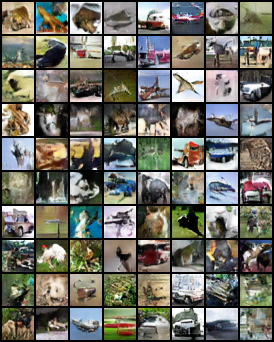

# Import Necessary Packages

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import random

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets
from torchvision import transforms # 张量变换
from torchvision.utils import save_image # 保存图片

from itertools import product # draw 10 * 10 images
from tqdm import tqdm

import matplotlib.pyplot as plt
# Enable Jupyter notebook plotting
%matplotlib inline

# Pytorch Version
print(torch.__version__)
print(torch.cuda.is_available())

1.7.0
True


# Hyper Parameters

In [2]:
cudnn.benchmark = True

#set manual seed to a constant get a consistent output
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

batch_size = 128
num_epoch = 200

ngf = 64  # base dimesion of G's feature
ndf = 64 # base dimesion of D's feature
z_dim = 100 # size of input noise's channel

nc = 3 # channels of output images

lr_G = 2e-4
lr_D = 2e-4 # leanring rate of Generator and Discriminator


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Random Seed:  6303
cuda:0


# Datasets files & utils

In [3]:
# the path we save data
if not os.path.exists('../../img'):
    os.mkdir('../../img')

# Transform of our datasets
trans = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])
    
# CIFAR10 datasets downloading……
cifar10 = datasets.CIFAR10(
    root = '../../data/cifar10/', train = True, transform = trans, download = True
)

# Dataloader
dataloader = torch.utils.data.DataLoader(
    dataset = cifar10, batch_size = batch_size, shuffle = True, num_workers = 8,
)



Files already downloaded and verified


In [4]:
inv_normalize = transforms.Normalize(
    mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
    std=[1/0.5, 1/0.5, 1/0.5]
)
# inv_tensor = inv_normalize(tensor)



# Discriminator Definitions (Vanilla DCGAN Fashion)
As mentioned, the discriminator, $D$, is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake).

Here, $D$ takes a 3x64x64 input image, processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function. 

This architecture can be extended with more layers if necessary for the problem, but there is significance to the use of the strided convolution, BatchNorm, and LeakyReLUs. 
The DCGAN paper mentions it is a good practice to use strided convolution rather than pooling to downsample because it lets the network learn its own pooling function. Also batch norm and leaky relu functions promote healthy gradient flow which is critical for the learning process of both $G$ and $D$.

It is a **unconditional** version.

In [5]:

class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.D = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, kernel_size = 4,
                      stride = 2, padding = 1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 18
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.D(x)
        return x

# Generator Definitions (Vanilla DCGAN Fashion)
The generator, $G$, is designed to map the latent space vector $(z)$ to data-space. Since our data are images, converting z to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of $[−1,1]$. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.

The generator, G, is designed to map the latent space vector $(z)$ to data-space. Since our data are images, converting z to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of $[−1,1]$. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.

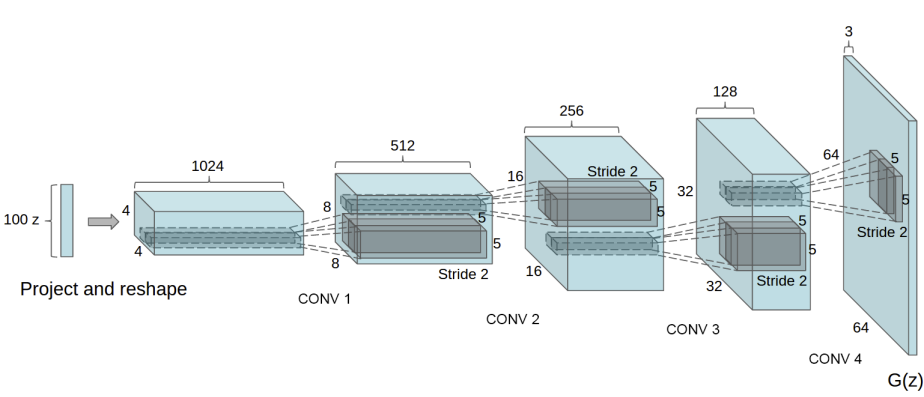

The final `Tanh` activataion function can project output into (-1,1)

Notice, the how the inputs we set in the input section (nz, ngf, and nc) influence the generator architecture in code. nz is the length of the z input vector, ngf relates to the size of the feature maps that are propagated through the generator, and nc is the number of channels in the output image (set to 3 for RGB images). Below is the code for the generator.


It is a **unconditional** version.

In [6]:

class generator(nn.Module):
    
    def __init__(self):
        super(generator, self).__init__()
        self.G = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4,
                              stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4,
                              stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, nc, kernel_size=4,
                              stride=2, padding=1, bias=False),
            # state size. nc x 32 x 32            
            nn.Tanh()
            )
        
    def forward(self, x):
        x = self.G(x)
        return x
        
        

## Weight Initialization
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.



In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Traning Phase
## Model & Opitmizer

In [8]:


D = discriminator()
G = generator()
D.apply(weights_init)
G.apply(weights_init)
# TODO: 自定义初始化

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = D.to(device)
G = G.to(device)




In [9]:
criterion = nn.BCELoss() # 二分类交叉熵

d_optimizer = torch.optim.Adam(D.parameters(), lr = lr_D, betas=(0.5,0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr = lr_G, betas=(0.5,0.999))

## Trainning Start!

In [10]:
G_losses = []
D_losses = []

for epoch in tqdm(range(num_epoch)):
    for i, (img, _) in enumerate(dataloader): # Since we don't need any labels, we make label be '_'

        # =============================== IMAGES =================================
        num_img = img.size(0) 
        #img = img.view(num_img, -1) # view()函数作用是将一个多行的Tensor,拼接成一行
                                    # 第一个参数是要拼接的tensor,第二个参数是-1
        # After view(), the input image will be a vector as 28 * 28 = 782 dimensions
        real_img = img.to(device) # the sampled data are real images
        # =============================== LABELS =================================
        real_label = (torch.ones(num_img) - 0.1).view(-1, 1).to(device) # Label of real images is 1
        fake_label = (torch.zeros(num_img) + 0.1).view(-1, 1).to(device) # label of real images is 0

        # ========================= D: Forward and Loss ==========================
        
        real_out = D(real_img).view(-1,1)
        d_loss_real = criterion(real_out, real_label) # TODO: criterion
        
        z = torch.randn(num_img, z_dim, 1, 1).to(device)
        #z = torch.randn(num_img, z_dim, 1, 1)
        
        fake_img = G(z)
        fake_out = D(fake_img).view(-1,1)
        d_loss_fake = criterion(fake_out, fake_label)
        
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad() # before back propagation
        d_loss.backward()
        d_optimizer.step()
        D_losses.append(d_loss)
        # =============== G ========================
        # To fool the Discriminator, we want G's fake output can get 'real' pridection
        z = torch.randn(num_img, z_dim, 1, 1).to(device)
        # z = torch.randn(num_img, z_dim, 1, 1)
        
        fake_img = G(z)
        fake_out = D(fake_img).view(-1,1)
        g_loss = criterion(fake_out, real_label)
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        G_losses.append(g_loss)
        # ============= Visualization ===============
        if i%100 == 0:
            print('Epoch[{}/{}],d_loss:{:.6f},g_loss:{:.6f} '
                  'D real: {:.6f},D fake: {:.6f}'.format(
                epoch,num_epoch,d_loss.item(),g_loss.item(),
                real_out.data.mean(),fake_out.data.mean()  #打印的是真实图片的损失均值
            ))
        
    if epoch == 0:
        real_images = inv_normalize(real_img.cpu().data)
        save_image(real_images, '../../img/real_images.png')
 
    fake_images = inv_normalize(fake_img.cpu().data)
    save_image(fake_images, '../../img/fake_images-{}.png'.format(epoch+1))

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch[0/200],d_loss:1.619233,g_loss:2.329610 D real: 0.658939,D fake: 0.094426
Epoch[0/200],d_loss:1.185688,g_loss:1.400514 D real: 0.533880,D fake: 0.238472
Epoch[0/200],d_loss:0.937303,g_loss:3.603653 D real: 0.781709,D fake: 0.020651
Epoch[0/200],d_loss:1.196551,g_loss:1.180997 D real: 0.542591,D fake: 0.303229


  0%|          | 1/200 [00:30<1:40:09, 30.20s/it]

Epoch[1/200],d_loss:1.121274,g_loss:1.799064 D real: 0.624984,D fake: 0.155100
Epoch[1/200],d_loss:0.941659,g_loss:1.900200 D real: 0.639923,D fake: 0.140261
Epoch[1/200],d_loss:1.334461,g_loss:2.624634 D real: 0.748847,D fake: 0.064864
Epoch[1/200],d_loss:1.036515,g_loss:1.663615 D real: 0.586517,D fake: 0.189929


  1%|          | 2/200 [00:58<1:37:45, 29.63s/it]

Epoch[2/200],d_loss:1.125382,g_loss:1.196762 D real: 0.550305,D fake: 0.305025
Epoch[2/200],d_loss:0.938168,g_loss:1.759485 D real: 0.753597,D fake: 0.171221
Epoch[2/200],d_loss:1.208934,g_loss:1.132209 D real: 0.501621,D fake: 0.320145
Epoch[2/200],d_loss:1.246922,g_loss:1.024197 D real: 0.578439,D fake: 0.367005


  2%|▏         | 3/200 [01:28<1:38:03, 29.86s/it]

Epoch[3/200],d_loss:1.081930,g_loss:1.691909 D real: 0.708572,D fake: 0.183786
Epoch[3/200],d_loss:1.007068,g_loss:1.170729 D real: 0.655101,D fake: 0.305610
Epoch[3/200],d_loss:1.071562,g_loss:1.573558 D real: 0.688248,D fake: 0.193777
Epoch[3/200],d_loss:1.012666,g_loss:1.537762 D real: 0.706743,D fake: 0.203100


  2%|▏         | 4/200 [02:03<1:42:02, 31.24s/it]

Epoch[4/200],d_loss:1.200877,g_loss:1.848772 D real: 0.787784,D fake: 0.149841
Epoch[4/200],d_loss:1.043646,g_loss:1.905315 D real: 0.783426,D fake: 0.133751
Epoch[4/200],d_loss:1.241693,g_loss:1.016718 D real: 0.478524,D fake: 0.373901
Epoch[4/200],d_loss:1.046104,g_loss:1.377486 D real: 0.638849,D fake: 0.249433


  2%|▎         | 5/200 [02:33<1:40:15, 30.85s/it]

Epoch[5/200],d_loss:1.235799,g_loss:1.468752 D real: 0.606509,D fake: 0.217123
Epoch[5/200],d_loss:1.118042,g_loss:1.076437 D real: 0.531821,D fake: 0.338063
Epoch[5/200],d_loss:1.172244,g_loss:1.161890 D real: 0.542349,D fake: 0.314588
Epoch[5/200],d_loss:1.183976,g_loss:0.927687 D real: 0.497360,D fake: 0.399184


  3%|▎         | 6/200 [03:03<1:38:58, 30.61s/it]

Epoch[6/200],d_loss:1.240024,g_loss:0.931419 D real: 0.491306,D fake: 0.398675
Epoch[6/200],d_loss:1.068728,g_loss:1.120892 D real: 0.554661,D fake: 0.322453
Epoch[6/200],d_loss:1.192320,g_loss:0.881042 D real: 0.509564,D fake: 0.418098
Epoch[6/200],d_loss:1.118472,g_loss:1.778611 D real: 0.704653,D fake: 0.156215


  4%|▎         | 7/200 [03:31<1:36:23, 29.97s/it]

Epoch[7/200],d_loss:1.067905,g_loss:1.140681 D real: 0.630990,D fake: 0.313974
Epoch[7/200],d_loss:1.104993,g_loss:1.264414 D real: 0.535300,D fake: 0.272854
Epoch[7/200],d_loss:0.957929,g_loss:1.442896 D real: 0.660374,D fake: 0.231926
Epoch[7/200],d_loss:1.031469,g_loss:0.999929 D real: 0.626360,D fake: 0.365184


  4%|▍         | 8/200 [04:04<1:38:15, 30.70s/it]

Epoch[8/200],d_loss:1.105008,g_loss:1.424788 D real: 0.662786,D fake: 0.229593
Epoch[8/200],d_loss:1.053196,g_loss:1.155141 D real: 0.583733,D fake: 0.306421
Epoch[8/200],d_loss:1.194801,g_loss:1.381145 D real: 0.799850,D fake: 0.240928
Epoch[8/200],d_loss:1.159764,g_loss:1.074123 D real: 0.556357,D fake: 0.335334


  4%|▍         | 9/200 [04:31<1:34:16, 29.61s/it]

Epoch[9/200],d_loss:1.102726,g_loss:1.372406 D real: 0.657817,D fake: 0.245603
Epoch[9/200],d_loss:1.087076,g_loss:1.027271 D real: 0.608111,D fake: 0.358900
Epoch[9/200],d_loss:1.080870,g_loss:0.848791 D real: 0.588064,D fake: 0.429142
Epoch[9/200],d_loss:1.237319,g_loss:1.142125 D real: 0.578481,D fake: 0.322066


  5%|▌         | 10/200 [05:04<1:36:59, 30.63s/it]

Epoch[10/200],d_loss:1.193278,g_loss:1.461675 D real: 0.672659,D fake: 0.222110
Epoch[10/200],d_loss:1.156316,g_loss:1.206483 D real: 0.644261,D fake: 0.290118
Epoch[10/200],d_loss:1.226961,g_loss:1.192277 D real: 0.646346,D fake: 0.301711
Epoch[10/200],d_loss:1.198422,g_loss:1.027141 D real: 0.623890,D fake: 0.357287


  6%|▌         | 11/200 [05:32<1:34:00, 29.84s/it]

Epoch[11/200],d_loss:1.172556,g_loss:0.892678 D real: 0.478809,D fake: 0.418768
Epoch[11/200],d_loss:1.239842,g_loss:1.590925 D real: 0.710639,D fake: 0.192043
Epoch[11/200],d_loss:1.282806,g_loss:0.679885 D real: 0.463987,D fake: 0.533399
Epoch[11/200],d_loss:1.262138,g_loss:0.996107 D real: 0.528045,D fake: 0.367608


  6%|▌         | 12/200 [06:01<1:32:40, 29.58s/it]

Epoch[12/200],d_loss:1.188438,g_loss:1.022059 D real: 0.599581,D fake: 0.354947
Epoch[12/200],d_loss:1.152987,g_loss:1.170618 D real: 0.529173,D fake: 0.303244
Epoch[12/200],d_loss:1.111363,g_loss:1.028923 D real: 0.659416,D fake: 0.352258
Epoch[12/200],d_loss:1.211343,g_loss:1.137503 D real: 0.610528,D fake: 0.314685


  6%|▋         | 13/200 [06:32<1:34:05, 30.19s/it]

Epoch[13/200],d_loss:1.076635,g_loss:1.332516 D real: 0.667734,D fake: 0.255749
Epoch[13/200],d_loss:1.393353,g_loss:0.693629 D real: 0.362703,D fake: 0.521701
Epoch[13/200],d_loss:1.103352,g_loss:1.079009 D real: 0.568802,D fake: 0.335194
Epoch[13/200],d_loss:1.124509,g_loss:1.013228 D real: 0.587440,D fake: 0.358596


  7%|▋         | 14/200 [07:04<1:34:58, 30.64s/it]

Epoch[14/200],d_loss:1.363463,g_loss:0.788500 D real: 0.395569,D fake: 0.465455
Epoch[14/200],d_loss:1.213930,g_loss:1.097140 D real: 0.490186,D fake: 0.326848
Epoch[14/200],d_loss:1.263319,g_loss:1.000337 D real: 0.454655,D fake: 0.367890
Epoch[14/200],d_loss:1.153054,g_loss:0.947221 D real: 0.553631,D fake: 0.391320


  8%|▊         | 15/200 [07:34<1:33:51, 30.44s/it]

Epoch[15/200],d_loss:1.162301,g_loss:1.436035 D real: 0.702359,D fake: 0.231589
Epoch[15/200],d_loss:1.144413,g_loss:1.069242 D real: 0.622637,D fake: 0.334316
Epoch[15/200],d_loss:1.181653,g_loss:1.193976 D real: 0.710503,D fake: 0.295793
Epoch[15/200],d_loss:1.423118,g_loss:2.161077 D real: 0.772584,D fake: 0.100290


  8%|▊         | 16/200 [08:04<1:33:02, 30.34s/it]

Epoch[16/200],d_loss:1.278814,g_loss:1.492702 D real: 0.779522,D fake: 0.213447
Epoch[16/200],d_loss:1.177878,g_loss:0.940903 D real: 0.555432,D fake: 0.388436
Epoch[16/200],d_loss:1.189152,g_loss:1.215738 D real: 0.572396,D fake: 0.293105
Epoch[16/200],d_loss:1.184544,g_loss:1.104159 D real: 0.625247,D fake: 0.322963


  8%|▊         | 17/200 [08:33<1:31:03, 29.86s/it]

Epoch[17/200],d_loss:1.167646,g_loss:1.196179 D real: 0.636094,D fake: 0.295786
Epoch[17/200],d_loss:1.158522,g_loss:1.051696 D real: 0.598600,D fake: 0.350942
Epoch[17/200],d_loss:1.211761,g_loss:0.919579 D real: 0.541921,D fake: 0.397887
Epoch[17/200],d_loss:1.187349,g_loss:1.257218 D real: 0.709169,D fake: 0.279427


  9%|▉         | 18/200 [09:04<1:31:19, 30.11s/it]

Epoch[18/200],d_loss:1.209536,g_loss:1.024931 D real: 0.561772,D fake: 0.357722
Epoch[18/200],d_loss:1.202365,g_loss:0.866621 D real: 0.523236,D fake: 0.424917
Epoch[18/200],d_loss:1.141774,g_loss:1.107701 D real: 0.557089,D fake: 0.324682
Epoch[18/200],d_loss:1.302100,g_loss:1.083432 D real: 0.527626,D fake: 0.331114


 10%|▉         | 19/200 [09:36<1:32:48, 30.77s/it]

Epoch[19/200],d_loss:1.200618,g_loss:0.919293 D real: 0.559752,D fake: 0.402343
Epoch[19/200],d_loss:1.137364,g_loss:1.378447 D real: 0.652479,D fake: 0.243147
Epoch[19/200],d_loss:1.277307,g_loss:1.067303 D real: 0.483270,D fake: 0.336437
Epoch[19/200],d_loss:1.331231,g_loss:0.979284 D real: 0.655224,D fake: 0.374135


 10%|█         | 20/200 [10:02<1:28:21, 29.45s/it]

Epoch[20/200],d_loss:1.229654,g_loss:1.028248 D real: 0.532625,D fake: 0.359633
Epoch[20/200],d_loss:1.280501,g_loss:1.003453 D real: 0.626615,D fake: 0.361532
Epoch[20/200],d_loss:1.416858,g_loss:0.629745 D real: 0.338199,D fake: 0.562968
Epoch[20/200],d_loss:1.238876,g_loss:1.342296 D real: 0.706524,D fake: 0.250597


 10%|█         | 21/200 [10:36<1:32:07, 30.88s/it]

Epoch[21/200],d_loss:1.207782,g_loss:1.394304 D real: 0.698722,D fake: 0.233145
Epoch[21/200],d_loss:1.182366,g_loss:0.756769 D real: 0.525743,D fake: 0.484400
Epoch[21/200],d_loss:1.118731,g_loss:0.809200 D real: 0.564801,D fake: 0.460277
Epoch[21/200],d_loss:1.287066,g_loss:0.929914 D real: 0.598026,D fake: 0.395112


 11%|█         | 22/200 [11:06<1:29:59, 30.33s/it]

Epoch[22/200],d_loss:1.235653,g_loss:0.814851 D real: 0.454670,D fake: 0.449736
Epoch[22/200],d_loss:1.191816,g_loss:0.948039 D real: 0.547924,D fake: 0.389333
Epoch[22/200],d_loss:1.243131,g_loss:0.795216 D real: 0.457305,D fake: 0.471313
Epoch[22/200],d_loss:1.066625,g_loss:0.853181 D real: 0.580731,D fake: 0.430219


 12%|█▏        | 23/200 [11:27<1:21:44, 27.71s/it]

Epoch[23/200],d_loss:1.139605,g_loss:1.178130 D real: 0.700487,D fake: 0.300707
Epoch[23/200],d_loss:1.120602,g_loss:1.113221 D real: 0.639149,D fake: 0.322665
Epoch[23/200],d_loss:1.081752,g_loss:1.358952 D real: 0.654691,D fake: 0.246176
Epoch[23/200],d_loss:1.022197,g_loss:1.426986 D real: 0.728116,D fake: 0.227733


 12%|█▏        | 24/200 [12:03<1:28:24, 30.14s/it]

Epoch[24/200],d_loss:1.168202,g_loss:1.110454 D real: 0.656320,D fake: 0.319970
Epoch[24/200],d_loss:1.173049,g_loss:1.121702 D real: 0.606448,D fake: 0.322511
Epoch[24/200],d_loss:1.120202,g_loss:1.044139 D real: 0.571783,D fake: 0.346536
Epoch[24/200],d_loss:1.112848,g_loss:0.978681 D real: 0.592813,D fake: 0.377096


 12%|█▎        | 25/200 [12:34<1:28:16, 30.27s/it]

Epoch[25/200],d_loss:1.149442,g_loss:1.043766 D real: 0.514990,D fake: 0.348037
Epoch[25/200],d_loss:1.166078,g_loss:1.069446 D real: 0.560785,D fake: 0.339469
Epoch[25/200],d_loss:1.159485,g_loss:1.047098 D real: 0.578511,D fake: 0.351428
Epoch[25/200],d_loss:1.093645,g_loss:1.367322 D real: 0.716987,D fake: 0.241581


 13%|█▎        | 26/200 [13:01<1:25:17, 29.41s/it]

Epoch[26/200],d_loss:1.158157,g_loss:1.134564 D real: 0.592897,D fake: 0.321442
Epoch[26/200],d_loss:1.363383,g_loss:1.315517 D real: 0.695041,D fake: 0.260006
Epoch[26/200],d_loss:1.242259,g_loss:1.380652 D real: 0.577540,D fake: 0.240051
Epoch[26/200],d_loss:1.241433,g_loss:1.208248 D real: 0.640884,D fake: 0.296153


 14%|█▎        | 27/200 [13:33<1:27:19, 30.29s/it]

Epoch[27/200],d_loss:1.232295,g_loss:1.397788 D real: 0.775813,D fake: 0.239306
Epoch[27/200],d_loss:1.131615,g_loss:1.234847 D real: 0.695066,D fake: 0.288293
Epoch[27/200],d_loss:1.432540,g_loss:0.881957 D real: 0.425818,D fake: 0.420097
Epoch[27/200],d_loss:1.100382,g_loss:1.052549 D real: 0.606977,D fake: 0.346071


 14%|█▍        | 28/200 [14:05<1:27:43, 30.60s/it]

Epoch[28/200],d_loss:1.082038,g_loss:1.120485 D real: 0.684705,D fake: 0.326073
Epoch[28/200],d_loss:1.123150,g_loss:1.017521 D real: 0.562339,D fake: 0.359836
Epoch[28/200],d_loss:1.075465,g_loss:0.956776 D real: 0.598060,D fake: 0.388008
Epoch[28/200],d_loss:1.070756,g_loss:1.146503 D real: 0.556506,D fake: 0.320170


 14%|█▍        | 29/200 [14:38<1:29:34, 31.43s/it]

Epoch[29/200],d_loss:1.084520,g_loss:1.146671 D real: 0.704729,D fake: 0.319711
Epoch[29/200],d_loss:1.073592,g_loss:1.292727 D real: 0.668624,D fake: 0.262088
Epoch[29/200],d_loss:1.224561,g_loss:0.586051 D real: 0.460959,D fake: 0.596915
Epoch[29/200],d_loss:1.116632,g_loss:0.738953 D real: 0.555670,D fake: 0.495820


 15%|█▌        | 30/200 [15:15<1:33:25, 32.97s/it]

Epoch[30/200],d_loss:1.193644,g_loss:1.348348 D real: 0.652718,D fake: 0.257519
Epoch[30/200],d_loss:1.215033,g_loss:1.562708 D real: 0.695820,D fake: 0.197772
Epoch[30/200],d_loss:1.155713,g_loss:1.165385 D real: 0.634593,D fake: 0.306151
Epoch[30/200],d_loss:1.103077,g_loss:1.366636 D real: 0.662292,D fake: 0.247616


 16%|█▌        | 31/200 [15:46<1:31:25, 32.46s/it]

Epoch[31/200],d_loss:1.081981,g_loss:1.089943 D real: 0.638260,D fake: 0.335031
Epoch[31/200],d_loss:1.047150,g_loss:1.077732 D real: 0.689393,D fake: 0.337005
Epoch[31/200],d_loss:1.122057,g_loss:1.343007 D real: 0.631932,D fake: 0.258303
Epoch[31/200],d_loss:1.268331,g_loss:1.255893 D real: 0.699482,D fake: 0.280684


 16%|█▌        | 32/200 [16:25<1:36:52, 34.60s/it]

Epoch[32/200],d_loss:1.162632,g_loss:1.080756 D real: 0.643881,D fake: 0.338082
Epoch[32/200],d_loss:1.219346,g_loss:0.882988 D real: 0.486465,D fake: 0.426059
Epoch[32/200],d_loss:1.065618,g_loss:1.043171 D real: 0.718115,D fake: 0.356085
Epoch[32/200],d_loss:1.184296,g_loss:0.614150 D real: 0.472037,D fake: 0.573340


 16%|█▋        | 33/200 [17:00<1:36:23, 34.63s/it]

Epoch[33/200],d_loss:1.294881,g_loss:1.396738 D real: 0.765214,D fake: 0.237376
Epoch[33/200],d_loss:1.089751,g_loss:1.260365 D real: 0.745220,D fake: 0.277878
Epoch[33/200],d_loss:0.996010,g_loss:1.079766 D real: 0.680621,D fake: 0.341160
Epoch[33/200],d_loss:1.154811,g_loss:0.525676 D real: 0.493772,D fake: 0.649384


 17%|█▋        | 34/200 [17:31<1:32:51, 33.57s/it]

Epoch[34/200],d_loss:1.042758,g_loss:1.176346 D real: 0.682911,D fake: 0.309707
Epoch[34/200],d_loss:1.046732,g_loss:1.021291 D real: 0.669197,D fake: 0.355334
Epoch[34/200],d_loss:1.145411,g_loss:0.754539 D real: 0.534818,D fake: 0.495116
Epoch[34/200],d_loss:1.910637,g_loss:0.454499 D real: 0.207351,D fake: 0.713166


 18%|█▊        | 35/200 [18:10<1:36:57, 35.26s/it]

Epoch[35/200],d_loss:1.151512,g_loss:0.953268 D real: 0.641406,D fake: 0.393349
Epoch[35/200],d_loss:1.158748,g_loss:1.432784 D real: 0.604140,D fake: 0.232094
Epoch[35/200],d_loss:1.078305,g_loss:1.005304 D real: 0.604108,D fake: 0.378716
Epoch[35/200],d_loss:1.074980,g_loss:0.992237 D real: 0.665250,D fake: 0.373478


 18%|█▊        | 36/200 [18:41<1:32:43, 33.92s/it]

Epoch[36/200],d_loss:1.064661,g_loss:1.296495 D real: 0.677436,D fake: 0.270234
Epoch[36/200],d_loss:0.978745,g_loss:1.034941 D real: 0.614508,D fake: 0.365514
Epoch[36/200],d_loss:1.008382,g_loss:1.230533 D real: 0.662041,D fake: 0.294767
Epoch[36/200],d_loss:0.988986,g_loss:1.069813 D real: 0.703442,D fake: 0.342153


 18%|█▊        | 37/200 [19:19<1:35:31, 35.16s/it]

Epoch[37/200],d_loss:0.985948,g_loss:1.235300 D real: 0.728731,D fake: 0.293863
Epoch[37/200],d_loss:1.169510,g_loss:0.872257 D real: 0.508062,D fake: 0.437389
Epoch[37/200],d_loss:1.217733,g_loss:1.606452 D real: 0.705953,D fake: 0.201589
Epoch[37/200],d_loss:1.131447,g_loss:1.044987 D real: 0.596960,D fake: 0.355991


 19%|█▉        | 38/200 [19:56<1:36:13, 35.64s/it]

Epoch[38/200],d_loss:1.014585,g_loss:1.238817 D real: 0.657441,D fake: 0.289562
Epoch[38/200],d_loss:1.145139,g_loss:1.139260 D real: 0.655295,D fake: 0.317341
Epoch[38/200],d_loss:1.198909,g_loss:1.683044 D real: 0.820222,D fake: 0.175907
Epoch[38/200],d_loss:1.146002,g_loss:0.940257 D real: 0.495165,D fake: 0.391260


 20%|█▉        | 39/200 [20:24<1:29:42, 33.43s/it]

Epoch[39/200],d_loss:1.045731,g_loss:0.982829 D real: 0.598985,D fake: 0.381560
Epoch[39/200],d_loss:1.169181,g_loss:1.155195 D real: 0.726028,D fake: 0.312170
Epoch[39/200],d_loss:0.943313,g_loss:1.314200 D real: 0.639127,D fake: 0.258993
Epoch[39/200],d_loss:1.308810,g_loss:1.228320 D real: 0.600731,D fake: 0.304156


 20%|██        | 40/200 [21:02<1:32:29, 34.68s/it]

Epoch[40/200],d_loss:0.994887,g_loss:1.156403 D real: 0.653736,D fake: 0.315310
Epoch[40/200],d_loss:0.922197,g_loss:1.256775 D real: 0.665996,D fake: 0.288922
Epoch[40/200],d_loss:1.000769,g_loss:1.205838 D real: 0.639630,D fake: 0.293952
Epoch[40/200],d_loss:1.130263,g_loss:1.042879 D real: 0.757393,D fake: 0.355864


 20%|██        | 41/200 [21:33<1:28:52, 33.54s/it]

Epoch[41/200],d_loss:1.008256,g_loss:0.942852 D real: 0.604776,D fake: 0.402576
Epoch[41/200],d_loss:1.009624,g_loss:1.220407 D real: 0.738025,D fake: 0.291652
Epoch[41/200],d_loss:1.016279,g_loss:1.247248 D real: 0.697700,D fake: 0.287337
Epoch[41/200],d_loss:1.030658,g_loss:1.198373 D real: 0.680708,D fake: 0.311225


 21%|██        | 42/200 [22:07<1:29:14, 33.89s/it]

Epoch[42/200],d_loss:1.066750,g_loss:1.520019 D real: 0.749255,D fake: 0.216798
Epoch[42/200],d_loss:1.085434,g_loss:1.187594 D real: 0.750342,D fake: 0.305704
Epoch[42/200],d_loss:1.109095,g_loss:1.463751 D real: 0.766192,D fake: 0.224923
Epoch[42/200],d_loss:1.018407,g_loss:0.753106 D real: 0.640394,D fake: 0.498240


 22%|██▏       | 43/200 [22:44<1:30:47, 34.70s/it]

Epoch[43/200],d_loss:1.004517,g_loss:0.868624 D real: 0.593032,D fake: 0.442675
Epoch[43/200],d_loss:1.033797,g_loss:1.235086 D real: 0.694334,D fake: 0.289607
Epoch[43/200],d_loss:1.096891,g_loss:0.883506 D real: 0.528710,D fake: 0.421456
Epoch[43/200],d_loss:1.010070,g_loss:1.048548 D real: 0.705506,D fake: 0.353887


 22%|██▏       | 44/200 [23:15<1:27:07, 33.51s/it]

Epoch[44/200],d_loss:1.025761,g_loss:1.174508 D real: 0.615823,D fake: 0.316398
Epoch[44/200],d_loss:0.987063,g_loss:1.348372 D real: 0.750802,D fake: 0.266606
Epoch[44/200],d_loss:1.005199,g_loss:1.039167 D real: 0.609551,D fake: 0.357822
Epoch[44/200],d_loss:1.045332,g_loss:1.246631 D real: 0.589686,D fake: 0.295028


 22%|██▎       | 45/200 [23:48<1:26:00, 33.29s/it]

Epoch[45/200],d_loss:1.026206,g_loss:0.946697 D real: 0.614239,D fake: 0.401734
Epoch[45/200],d_loss:1.031523,g_loss:1.164644 D real: 0.692304,D fake: 0.324816
Epoch[45/200],d_loss:0.991695,g_loss:1.080603 D real: 0.616959,D fake: 0.346445
Epoch[45/200],d_loss:1.005045,g_loss:1.483870 D real: 0.719316,D fake: 0.229031


 23%|██▎       | 46/200 [24:22<1:26:14, 33.60s/it]

Epoch[46/200],d_loss:0.990641,g_loss:1.537293 D real: 0.758152,D fake: 0.214030
Epoch[46/200],d_loss:1.159387,g_loss:0.659474 D real: 0.468718,D fake: 0.545085
Epoch[46/200],d_loss:1.168622,g_loss:1.502792 D real: 0.672432,D fake: 0.222593
Epoch[46/200],d_loss:1.060381,g_loss:1.260751 D real: 0.703357,D fake: 0.277538


 24%|██▎       | 47/200 [24:57<1:26:57, 34.10s/it]

Epoch[47/200],d_loss:0.990976,g_loss:1.189910 D real: 0.607502,D fake: 0.312129
Epoch[47/200],d_loss:1.087219,g_loss:1.394766 D real: 0.703324,D fake: 0.240301
Epoch[47/200],d_loss:1.055740,g_loss:0.898470 D real: 0.571926,D fake: 0.424467
Epoch[47/200],d_loss:1.009838,g_loss:1.515853 D real: 0.753956,D fake: 0.218760


 24%|██▍       | 48/200 [25:32<1:26:45, 34.25s/it]

Epoch[48/200],d_loss:1.016935,g_loss:0.992625 D real: 0.658575,D fake: 0.378081
Epoch[48/200],d_loss:1.089018,g_loss:0.836280 D real: 0.513740,D fake: 0.455031
Epoch[48/200],d_loss:0.947448,g_loss:1.060827 D real: 0.683102,D fake: 0.362063
Epoch[48/200],d_loss:1.075707,g_loss:1.510677 D real: 0.782216,D fake: 0.231507


 24%|██▍       | 49/200 [26:03<1:23:39, 33.24s/it]

Epoch[49/200],d_loss:0.967741,g_loss:1.238063 D real: 0.776671,D fake: 0.290332
Epoch[49/200],d_loss:0.971501,g_loss:1.106014 D real: 0.656316,D fake: 0.341972
Epoch[49/200],d_loss:0.995319,g_loss:1.330145 D real: 0.723158,D fake: 0.266488
Epoch[49/200],d_loss:1.056221,g_loss:1.469491 D real: 0.729734,D fake: 0.228021


 25%|██▌       | 50/200 [26:40<1:26:13, 34.49s/it]

Epoch[50/200],d_loss:0.956168,g_loss:1.209145 D real: 0.637911,D fake: 0.292818
Epoch[50/200],d_loss:1.021504,g_loss:1.067902 D real: 0.574040,D fake: 0.355439
Epoch[50/200],d_loss:0.892889,g_loss:1.207669 D real: 0.696709,D fake: 0.304825
Epoch[50/200],d_loss:1.095940,g_loss:1.147078 D real: 0.509033,D fake: 0.322182


 26%|██▌       | 51/200 [27:16<1:27:04, 35.06s/it]

Epoch[51/200],d_loss:1.249575,g_loss:1.645899 D real: 0.885243,D fake: 0.187877
Epoch[51/200],d_loss:0.952003,g_loss:1.441028 D real: 0.691806,D fake: 0.240976
Epoch[51/200],d_loss:0.981954,g_loss:1.086712 D real: 0.604577,D fake: 0.344741
Epoch[51/200],d_loss:0.890672,g_loss:1.488550 D real: 0.699759,D fake: 0.222936


 26%|██▌       | 52/200 [27:47<1:23:07, 33.70s/it]

Epoch[52/200],d_loss:0.975814,g_loss:1.231328 D real: 0.721825,D fake: 0.296853
Epoch[52/200],d_loss:1.153682,g_loss:0.853272 D real: 0.534613,D fake: 0.453918
Epoch[52/200],d_loss:0.992304,g_loss:1.759895 D real: 0.781748,D fake: 0.170936
Epoch[52/200],d_loss:1.006337,g_loss:1.252775 D real: 0.683147,D fake: 0.290218


 26%|██▋       | 53/200 [28:31<1:29:50, 36.67s/it]

Epoch[53/200],d_loss:1.058499,g_loss:1.651928 D real: 0.773095,D fake: 0.192828
Epoch[53/200],d_loss:1.016833,g_loss:1.221466 D real: 0.660708,D fake: 0.304572
Epoch[53/200],d_loss:1.007522,g_loss:1.546391 D real: 0.767752,D fake: 0.213589
Epoch[53/200],d_loss:0.922637,g_loss:1.215627 D real: 0.724989,D fake: 0.299635


 27%|██▋       | 54/200 [29:03<1:26:13, 35.44s/it]

Epoch[54/200],d_loss:1.004130,g_loss:1.501445 D real: 0.712442,D fake: 0.225701
Epoch[54/200],d_loss:1.014478,g_loss:1.642791 D real: 0.750520,D fake: 0.195662
Epoch[54/200],d_loss:1.013288,g_loss:1.767706 D real: 0.859431,D fake: 0.166174
Epoch[54/200],d_loss:1.049650,g_loss:1.313619 D real: 0.685464,D fake: 0.278398


 28%|██▊       | 55/200 [29:43<1:28:36, 36.67s/it]

Epoch[55/200],d_loss:0.863675,g_loss:1.433324 D real: 0.741084,D fake: 0.245612
Epoch[55/200],d_loss:1.141082,g_loss:0.698481 D real: 0.489604,D fake: 0.521236
Epoch[55/200],d_loss:1.016804,g_loss:1.372989 D real: 0.671147,D fake: 0.257736
Epoch[55/200],d_loss:0.973138,g_loss:1.044025 D real: 0.612317,D fake: 0.367130


 28%|██▊       | 56/200 [30:15<1:25:11, 35.50s/it]

Epoch[56/200],d_loss:0.974719,g_loss:1.908625 D real: 0.806647,D fake: 0.153113
Epoch[56/200],d_loss:1.031219,g_loss:0.948167 D real: 0.556821,D fake: 0.414547
Epoch[56/200],d_loss:1.018155,g_loss:1.485540 D real: 0.696709,D fake: 0.237066
Epoch[56/200],d_loss:1.099327,g_loss:0.948640 D real: 0.554616,D fake: 0.407497


 28%|██▊       | 57/200 [30:49<1:23:04, 34.85s/it]

Epoch[57/200],d_loss:0.917078,g_loss:1.868328 D real: 0.702895,D fake: 0.150067
Epoch[57/200],d_loss:1.065817,g_loss:1.581939 D real: 0.687966,D fake: 0.213520
Epoch[57/200],d_loss:1.066093,g_loss:1.550188 D real: 0.809397,D fake: 0.214850
Epoch[57/200],d_loss:2.063110,g_loss:2.815989 D real: 0.928125,D fake: 0.056838


 29%|██▉       | 58/200 [31:28<1:25:41, 36.21s/it]

Epoch[58/200],d_loss:0.972203,g_loss:1.597152 D real: 0.821345,D fake: 0.202553
Epoch[58/200],d_loss:1.007687,g_loss:1.049819 D real: 0.564579,D fake: 0.370002
Epoch[58/200],d_loss:0.954580,g_loss:1.116662 D real: 0.647876,D fake: 0.335489
Epoch[58/200],d_loss:1.001281,g_loss:1.611775 D real: 0.778114,D fake: 0.196522


 30%|██▉       | 59/200 [31:57<1:20:10, 34.11s/it]

Epoch[59/200],d_loss:1.116647,g_loss:1.869591 D real: 0.815227,D fake: 0.160632
Epoch[59/200],d_loss:0.878885,g_loss:1.507001 D real: 0.749370,D fake: 0.226434
Epoch[59/200],d_loss:0.998595,g_loss:1.684526 D real: 0.797348,D fake: 0.185373
Epoch[59/200],d_loss:0.953612,g_loss:1.569894 D real: 0.817882,D fake: 0.215217


 30%|███       | 60/200 [32:33<1:20:46, 34.62s/it]

Epoch[60/200],d_loss:0.952462,g_loss:1.160220 D real: 0.805024,D fake: 0.322973
Epoch[60/200],d_loss:0.915177,g_loss:1.427035 D real: 0.769639,D fake: 0.237777
Epoch[60/200],d_loss:0.916552,g_loss:1.453191 D real: 0.723941,D fake: 0.234061
Epoch[60/200],d_loss:1.044863,g_loss:1.292124 D real: 0.679711,D fake: 0.286779


 30%|███       | 61/200 [33:09<1:20:53, 34.92s/it]

Epoch[61/200],d_loss:1.024772,g_loss:1.432777 D real: 0.705503,D fake: 0.246836
Epoch[61/200],d_loss:0.902346,g_loss:1.251983 D real: 0.720307,D fake: 0.290853
Epoch[61/200],d_loss:0.924384,g_loss:1.269946 D real: 0.739907,D fake: 0.293744
Epoch[61/200],d_loss:0.991912,g_loss:1.275832 D real: 0.612785,D fake: 0.284891


 31%|███       | 62/200 [33:34<1:13:45, 32.07s/it]

Epoch[62/200],d_loss:0.915149,g_loss:1.358985 D real: 0.736874,D fake: 0.257652
Epoch[62/200],d_loss:0.982277,g_loss:1.808738 D real: 0.794804,D fake: 0.167343
Epoch[62/200],d_loss:0.997491,g_loss:1.313462 D real: 0.606875,D fake: 0.288592
Epoch[62/200],d_loss:0.937842,g_loss:1.231115 D real: 0.736906,D fake: 0.290561


 32%|███▏      | 63/200 [34:09<1:15:17, 32.97s/it]

Epoch[63/200],d_loss:0.903516,g_loss:1.510376 D real: 0.659626,D fake: 0.230803
Epoch[63/200],d_loss:0.924571,g_loss:1.804654 D real: 0.804524,D fake: 0.175790
Epoch[63/200],d_loss:0.886976,g_loss:1.324945 D real: 0.742540,D fake: 0.277586
Epoch[63/200],d_loss:1.023606,g_loss:1.781136 D real: 0.837795,D fake: 0.178550


 32%|███▏      | 64/200 [34:44<1:15:53, 33.48s/it]

Epoch[64/200],d_loss:0.936374,g_loss:1.591408 D real: 0.790773,D fake: 0.206439
Epoch[64/200],d_loss:0.854517,g_loss:1.376205 D real: 0.779688,D fake: 0.255486
Epoch[64/200],d_loss:0.970671,g_loss:1.164425 D real: 0.629292,D fake: 0.332517
Epoch[64/200],d_loss:0.954721,g_loss:1.604426 D real: 0.795806,D fake: 0.206361


 32%|███▎      | 65/200 [35:18<1:16:02, 33.80s/it]

Epoch[65/200],d_loss:0.889135,g_loss:1.308383 D real: 0.685045,D fake: 0.285479
Epoch[65/200],d_loss:1.093128,g_loss:1.987211 D real: 0.824358,D fake: 0.142828
Epoch[65/200],d_loss:0.895434,g_loss:1.931793 D real: 0.797562,D fake: 0.146279
Epoch[65/200],d_loss:0.981519,g_loss:1.561117 D real: 0.811577,D fake: 0.223899


 33%|███▎      | 66/200 [35:51<1:14:44, 33.47s/it]

Epoch[66/200],d_loss:0.929111,g_loss:1.798184 D real: 0.795067,D fake: 0.172246
Epoch[66/200],d_loss:0.876237,g_loss:1.286883 D real: 0.746234,D fake: 0.272888
Epoch[66/200],d_loss:1.082767,g_loss:2.212776 D real: 0.855462,D fake: 0.107432
Epoch[66/200],d_loss:0.916296,g_loss:1.659848 D real: 0.765629,D fake: 0.189396


 34%|███▎      | 67/200 [36:24<1:13:32, 33.18s/it]

Epoch[67/200],d_loss:1.069908,g_loss:1.614867 D real: 0.784167,D fake: 0.200161
Epoch[67/200],d_loss:0.824046,g_loss:1.824198 D real: 0.788163,D fake: 0.159802
Epoch[67/200],d_loss:0.885830,g_loss:1.340855 D real: 0.725948,D fake: 0.270686
Epoch[67/200],d_loss:0.880300,g_loss:1.837881 D real: 0.761024,D fake: 0.162489


 34%|███▍      | 68/200 [37:03<1:17:01, 35.01s/it]

Epoch[68/200],d_loss:0.940539,g_loss:1.324424 D real: 0.653762,D fake: 0.280556
Epoch[68/200],d_loss:0.826623,g_loss:1.428188 D real: 0.780227,D fake: 0.248950
Epoch[68/200],d_loss:0.866240,g_loss:1.310142 D real: 0.671548,D fake: 0.280694
Epoch[68/200],d_loss:1.217910,g_loss:0.888053 D real: 0.530121,D fake: 0.453369


 34%|███▍      | 69/200 [37:39<1:17:18, 35.41s/it]

Epoch[69/200],d_loss:0.803706,g_loss:1.397135 D real: 0.834997,D fake: 0.251089
Epoch[69/200],d_loss:0.923728,g_loss:1.681064 D real: 0.705336,D fake: 0.187970
Epoch[69/200],d_loss:0.837263,g_loss:1.750365 D real: 0.761481,D fake: 0.174702
Epoch[69/200],d_loss:1.035302,g_loss:2.140734 D real: 0.758530,D fake: 0.117867


 35%|███▌      | 70/200 [38:06<1:11:09, 32.84s/it]

Epoch[70/200],d_loss:0.732467,g_loss:1.772745 D real: 0.816883,D fake: 0.175345
Epoch[70/200],d_loss:0.881130,g_loss:1.157844 D real: 0.703544,D fake: 0.330015
Epoch[70/200],d_loss:0.973629,g_loss:1.885853 D real: 0.855858,D fake: 0.151286
Epoch[70/200],d_loss:0.922790,g_loss:1.321409 D real: 0.738443,D fake: 0.279264


 36%|███▌      | 71/200 [38:43<1:13:13, 34.06s/it]

Epoch[71/200],d_loss:0.893374,g_loss:1.613760 D real: 0.768654,D fake: 0.204571
Epoch[71/200],d_loss:0.905754,g_loss:1.547700 D real: 0.807003,D fake: 0.218633
Epoch[71/200],d_loss:0.928198,g_loss:0.988971 D real: 0.621188,D fake: 0.400273
Epoch[71/200],d_loss:0.936064,g_loss:1.364515 D real: 0.773813,D fake: 0.263068


 36%|███▌      | 72/200 [39:17<1:12:31, 34.00s/it]

Epoch[72/200],d_loss:0.801316,g_loss:1.385105 D real: 0.757944,D fake: 0.259596
Epoch[72/200],d_loss:1.011232,g_loss:0.722436 D real: 0.572281,D fake: 0.531163
Epoch[72/200],d_loss:0.952202,g_loss:0.981998 D real: 0.669511,D fake: 0.398159
Epoch[72/200],d_loss:0.897303,g_loss:1.382941 D real: 0.711094,D fake: 0.267399


 36%|███▋      | 73/200 [39:46<1:08:42, 32.46s/it]

Epoch[73/200],d_loss:1.113390,g_loss:1.044788 D real: 0.497114,D fake: 0.384055
Epoch[73/200],d_loss:1.078838,g_loss:1.586402 D real: 0.549242,D fake: 0.230962
Epoch[73/200],d_loss:0.824433,g_loss:1.785655 D real: 0.809561,D fake: 0.181985
Epoch[73/200],d_loss:0.966335,g_loss:1.226756 D real: 0.609555,D fake: 0.307385


 37%|███▋      | 74/200 [40:19<1:08:57, 32.84s/it]

Epoch[74/200],d_loss:0.897730,g_loss:1.266456 D real: 0.682154,D fake: 0.291877
Epoch[74/200],d_loss:0.890609,g_loss:1.369411 D real: 0.707333,D fake: 0.271386
Epoch[74/200],d_loss:0.934443,g_loss:2.141366 D real: 0.793508,D fake: 0.119598
Epoch[74/200],d_loss:0.901890,g_loss:1.820951 D real: 0.788767,D fake: 0.163853


 38%|███▊      | 75/200 [40:53<1:08:37, 32.94s/it]

Epoch[75/200],d_loss:0.882228,g_loss:1.239289 D real: 0.664402,D fake: 0.311589
Epoch[75/200],d_loss:0.968857,g_loss:2.340362 D real: 0.890883,D fake: 0.095030
Epoch[75/200],d_loss:0.816478,g_loss:2.028597 D real: 0.811901,D fake: 0.134129
Epoch[75/200],d_loss:0.879152,g_loss:1.351352 D real: 0.732545,D fake: 0.266903


 38%|███▊      | 76/200 [41:29<1:10:16, 34.00s/it]

Epoch[76/200],d_loss:0.841049,g_loss:2.083588 D real: 0.853389,D fake: 0.121834
Epoch[76/200],d_loss:0.805292,g_loss:1.585994 D real: 0.835839,D fake: 0.214199
Epoch[76/200],d_loss:0.817704,g_loss:1.635106 D real: 0.774460,D fake: 0.201673
Epoch[76/200],d_loss:0.885744,g_loss:1.445156 D real: 0.756999,D fake: 0.243486


 38%|███▊      | 77/200 [42:00<1:07:57, 33.15s/it]

Epoch[77/200],d_loss:0.843194,g_loss:1.399938 D real: 0.804432,D fake: 0.259282
Epoch[77/200],d_loss:1.027090,g_loss:1.271274 D real: 0.544243,D fake: 0.297184
Epoch[77/200],d_loss:0.790038,g_loss:2.046503 D real: 0.795654,D fake: 0.126945
Epoch[77/200],d_loss:0.915870,g_loss:1.859978 D real: 0.909564,D fake: 0.163041


 39%|███▉      | 78/200 [42:34<1:07:43, 33.31s/it]

Epoch[78/200],d_loss:0.993731,g_loss:0.916175 D real: 0.570639,D fake: 0.430345
Epoch[78/200],d_loss:0.935970,g_loss:1.980381 D real: 0.814304,D fake: 0.142487
Epoch[78/200],d_loss:1.032295,g_loss:0.730078 D real: 0.546728,D fake: 0.542408
Epoch[78/200],d_loss:0.901905,g_loss:1.574944 D real: 0.684066,D fake: 0.216591


 40%|███▉      | 79/200 [43:10<1:08:50, 34.13s/it]

Epoch[79/200],d_loss:0.844645,g_loss:1.674298 D real: 0.735802,D fake: 0.198037
Epoch[79/200],d_loss:0.917068,g_loss:1.498553 D real: 0.649421,D fake: 0.231570
Epoch[79/200],d_loss:0.895181,g_loss:1.668396 D real: 0.759912,D fake: 0.199761
Epoch[79/200],d_loss:0.905715,g_loss:1.327817 D real: 0.722315,D fake: 0.273779


 40%|████      | 80/200 [43:44<1:08:14, 34.12s/it]

Epoch[80/200],d_loss:0.834446,g_loss:1.693148 D real: 0.759427,D fake: 0.191068
Epoch[80/200],d_loss:0.845435,g_loss:1.320193 D real: 0.716465,D fake: 0.280139
Epoch[80/200],d_loss:0.843930,g_loss:1.540949 D real: 0.774868,D fake: 0.221983
Epoch[80/200],d_loss:0.788419,g_loss:1.946301 D real: 0.775181,D fake: 0.149414


 40%|████      | 81/200 [44:18<1:07:29, 34.03s/it]

Epoch[81/200],d_loss:0.859806,g_loss:1.520802 D real: 0.814940,D fake: 0.218307
Epoch[81/200],d_loss:0.896711,g_loss:1.159919 D real: 0.664551,D fake: 0.327926
Epoch[81/200],d_loss:1.020422,g_loss:2.413690 D real: 0.902992,D fake: 0.094717
Epoch[81/200],d_loss:1.191312,g_loss:0.467925 D real: 0.452291,D fake: 0.726197


 41%|████      | 82/200 [44:59<1:11:06, 36.16s/it]

Epoch[82/200],d_loss:0.887402,g_loss:1.837147 D real: 0.797623,D fake: 0.169859
Epoch[82/200],d_loss:0.908913,g_loss:1.176046 D real: 0.661429,D fake: 0.329748
Epoch[82/200],d_loss:0.763292,g_loss:1.570440 D real: 0.788086,D fake: 0.212559
Epoch[82/200],d_loss:0.846964,g_loss:1.549336 D real: 0.809910,D fake: 0.215229


 42%|████▏     | 83/200 [45:31<1:08:09, 34.96s/it]

Epoch[83/200],d_loss:0.724047,g_loss:1.921869 D real: 0.889487,D fake: 0.144106
Epoch[83/200],d_loss:0.798410,g_loss:1.677058 D real: 0.752700,D fake: 0.189630
Epoch[83/200],d_loss:0.828754,g_loss:1.668734 D real: 0.771779,D fake: 0.198776
Epoch[83/200],d_loss:1.149829,g_loss:0.913118 D real: 0.565845,D fake: 0.450674


 42%|████▏     | 84/200 [46:06<1:07:25, 34.87s/it]

Epoch[84/200],d_loss:0.835387,g_loss:1.880942 D real: 0.755627,D fake: 0.160109
Epoch[84/200],d_loss:0.756073,g_loss:1.575143 D real: 0.814460,D fake: 0.218080
Epoch[84/200],d_loss:0.935732,g_loss:1.279462 D real: 0.601909,D fake: 0.280165
Epoch[84/200],d_loss:0.901253,g_loss:2.008474 D real: 0.834761,D fake: 0.129916


 42%|████▎     | 85/200 [46:38<1:05:27, 34.15s/it]

Epoch[85/200],d_loss:0.755690,g_loss:1.484715 D real: 0.830011,D fake: 0.232139
Epoch[85/200],d_loss:0.988871,g_loss:0.853030 D real: 0.564006,D fake: 0.464575
Epoch[85/200],d_loss:0.796413,g_loss:1.625621 D real: 0.759497,D fake: 0.204859
Epoch[85/200],d_loss:0.851068,g_loss:1.050920 D real: 0.728531,D fake: 0.370963


 43%|████▎     | 86/200 [47:14<1:05:39, 34.55s/it]

Epoch[86/200],d_loss:1.175220,g_loss:0.963457 D real: 0.465788,D fake: 0.410422
Epoch[86/200],d_loss:0.885225,g_loss:1.773269 D real: 0.686356,D fake: 0.174696
Epoch[86/200],d_loss:0.840020,g_loss:1.407885 D real: 0.720038,D fake: 0.253963
Epoch[86/200],d_loss:0.850925,g_loss:1.235384 D real: 0.716367,D fake: 0.307934


 44%|████▎     | 87/200 [47:45<1:02:53, 33.40s/it]

Epoch[87/200],d_loss:0.866536,g_loss:1.664535 D real: 0.805298,D fake: 0.203320
Epoch[87/200],d_loss:0.876077,g_loss:1.772219 D real: 0.766924,D fake: 0.177404
Epoch[87/200],d_loss:0.875788,g_loss:2.354100 D real: 0.825890,D fake: 0.098308
Epoch[87/200],d_loss:3.440654,g_loss:0.450332 D real: 0.145355,D fake: 0.859834


 44%|████▍     | 88/200 [48:16<1:01:24, 32.90s/it]

Epoch[88/200],d_loss:0.892731,g_loss:1.451399 D real: 0.703692,D fake: 0.271967
Epoch[88/200],d_loss:0.821590,g_loss:1.169986 D real: 0.725349,D fake: 0.324776
Epoch[88/200],d_loss:0.837567,g_loss:1.455630 D real: 0.796211,D fake: 0.240553
Epoch[88/200],d_loss:0.773568,g_loss:1.899219 D real: 0.846260,D fake: 0.157612


 44%|████▍     | 89/200 [48:58<1:05:40, 35.50s/it]

Epoch[89/200],d_loss:0.772876,g_loss:2.156703 D real: 0.825900,D fake: 0.114777
Epoch[89/200],d_loss:0.766176,g_loss:1.527925 D real: 0.843790,D fake: 0.231379
Epoch[89/200],d_loss:0.962476,g_loss:1.482381 D real: 0.622569,D fake: 0.248380
Epoch[89/200],d_loss:0.807667,g_loss:1.424624 D real: 0.760746,D fake: 0.246769


 45%|████▌     | 90/200 [49:31<1:03:51, 34.83s/it]

Epoch[90/200],d_loss:0.806243,g_loss:1.556054 D real: 0.851011,D fake: 0.214561
Epoch[90/200],d_loss:0.739128,g_loss:1.757553 D real: 0.847503,D fake: 0.177585
Epoch[90/200],d_loss:0.776330,g_loss:1.979698 D real: 0.789601,D fake: 0.135939
Epoch[90/200],d_loss:0.834087,g_loss:1.465385 D real: 0.780813,D fake: 0.238689


 46%|████▌     | 91/200 [50:12<1:06:36, 36.67s/it]

Epoch[91/200],d_loss:0.834863,g_loss:1.319770 D real: 0.731207,D fake: 0.286286
Epoch[91/200],d_loss:0.784381,g_loss:1.581500 D real: 0.799510,D fake: 0.221253
Epoch[91/200],d_loss:1.116244,g_loss:1.819366 D real: 0.901659,D fake: 0.177715
Epoch[91/200],d_loss:0.843898,g_loss:1.311669 D real: 0.733291,D fake: 0.288281


 46%|████▌     | 92/200 [50:50<1:06:52, 37.15s/it]

Epoch[92/200],d_loss:0.913949,g_loss:2.196592 D real: 0.889379,D fake: 0.103918
Epoch[92/200],d_loss:0.759250,g_loss:1.651281 D real: 0.790703,D fake: 0.197229
Epoch[92/200],d_loss:0.795461,g_loss:1.783151 D real: 0.829651,D fake: 0.179757
Epoch[92/200],d_loss:1.614496,g_loss:3.902386 D real: 0.935005,D fake: 0.020275


 46%|████▋     | 93/200 [51:21<1:02:37, 35.11s/it]

Epoch[93/200],d_loss:0.878719,g_loss:1.840960 D real: 0.842147,D fake: 0.170752
Epoch[93/200],d_loss:0.843567,g_loss:1.216354 D real: 0.737943,D fake: 0.315648
Epoch[93/200],d_loss:1.143205,g_loss:0.949528 D real: 0.517902,D fake: 0.421659
Epoch[93/200],d_loss:0.824628,g_loss:1.736749 D real: 0.763510,D fake: 0.183778


 47%|████▋     | 94/200 [52:02<1:05:13, 36.92s/it]

Epoch[94/200],d_loss:0.872205,g_loss:2.036604 D real: 0.840352,D fake: 0.139105
Epoch[94/200],d_loss:0.787302,g_loss:1.890562 D real: 0.848160,D fake: 0.157322
Epoch[94/200],d_loss:1.003299,g_loss:1.208611 D real: 0.581183,D fake: 0.313546
Epoch[94/200],d_loss:0.813814,g_loss:1.666389 D real: 0.764442,D fake: 0.196847


 48%|████▊     | 95/200 [52:34<1:01:51, 35.35s/it]

Epoch[95/200],d_loss:0.831541,g_loss:1.589925 D real: 0.721371,D fake: 0.217074
Epoch[95/200],d_loss:0.820024,g_loss:2.442345 D real: 0.850430,D fake: 0.087186
Epoch[95/200],d_loss:0.866806,g_loss:1.599774 D real: 0.712171,D fake: 0.206114
Epoch[95/200],d_loss:0.797885,g_loss:1.806810 D real: 0.786356,D fake: 0.169812


 48%|████▊     | 96/200 [53:02<57:42, 33.30s/it]  

Epoch[96/200],d_loss:0.871799,g_loss:1.275287 D real: 0.676553,D fake: 0.296850
Epoch[96/200],d_loss:0.819835,g_loss:1.563005 D real: 0.780873,D fake: 0.221062
Epoch[96/200],d_loss:0.807037,g_loss:1.492045 D real: 0.818612,D fake: 0.240079
Epoch[96/200],d_loss:0.785024,g_loss:1.915274 D real: 0.737630,D fake: 0.154696


 48%|████▊     | 97/200 [53:37<58:05, 33.84s/it]

Epoch[97/200],d_loss:0.820979,g_loss:1.981956 D real: 0.803869,D fake: 0.146546
Epoch[97/200],d_loss:0.815487,g_loss:2.124349 D real: 0.908689,D fake: 0.122267
Epoch[97/200],d_loss:0.808950,g_loss:1.566008 D real: 0.790305,D fake: 0.229123
Epoch[97/200],d_loss:0.883474,g_loss:1.362639 D real: 0.647245,D fake: 0.273442


 49%|████▉     | 98/200 [54:10<56:54, 33.47s/it]

Epoch[98/200],d_loss:0.829404,g_loss:2.045527 D real: 0.905159,D fake: 0.143369
Epoch[98/200],d_loss:0.838195,g_loss:2.212842 D real: 0.897055,D fake: 0.111657
Epoch[98/200],d_loss:0.786262,g_loss:1.674167 D real: 0.789500,D fake: 0.199634
Epoch[98/200],d_loss:0.866797,g_loss:1.668820 D real: 0.729412,D fake: 0.204378


 50%|████▉     | 99/200 [54:47<58:23, 34.69s/it]

Epoch[99/200],d_loss:0.858936,g_loss:1.528169 D real: 0.678882,D fake: 0.237303
Epoch[99/200],d_loss:0.765740,g_loss:1.604905 D real: 0.776149,D fake: 0.204548
Epoch[99/200],d_loss:0.752391,g_loss:1.658026 D real: 0.840652,D fake: 0.199071
Epoch[99/200],d_loss:0.949575,g_loss:1.317687 D real: 0.591512,D fake: 0.298641


 50%|█████     | 100/200 [55:24<58:34, 35.15s/it]

Epoch[100/200],d_loss:0.870547,g_loss:1.368906 D real: 0.688377,D fake: 0.267420
Epoch[100/200],d_loss:0.820105,g_loss:1.468308 D real: 0.790311,D fake: 0.242537
Epoch[100/200],d_loss:0.763362,g_loss:1.497988 D real: 0.836182,D fake: 0.240373
Epoch[100/200],d_loss:0.786070,g_loss:1.126464 D real: 0.734901,D fake: 0.342579


 50%|█████     | 101/200 [55:59<58:05, 35.21s/it]

Epoch[101/200],d_loss:0.788491,g_loss:1.978623 D real: 0.845255,D fake: 0.140980
Epoch[101/200],d_loss:0.859982,g_loss:2.158878 D real: 0.841259,D fake: 0.110071
Epoch[101/200],d_loss:0.797058,g_loss:1.449006 D real: 0.772625,D fake: 0.257612
Epoch[101/200],d_loss:0.901487,g_loss:1.589564 D real: 0.653289,D fake: 0.219636


 51%|█████     | 102/200 [56:37<59:08, 36.20s/it]

Epoch[102/200],d_loss:0.771743,g_loss:1.787602 D real: 0.829809,D fake: 0.176771
Epoch[102/200],d_loss:0.833795,g_loss:1.849371 D real: 0.876940,D fake: 0.173187
Epoch[102/200],d_loss:0.719613,g_loss:1.626661 D real: 0.865043,D fake: 0.201076
Epoch[102/200],d_loss:0.844097,g_loss:2.049794 D real: 0.760611,D fake: 0.128255


 52%|█████▏    | 103/200 [57:06<54:44, 33.86s/it]

Epoch[103/200],d_loss:1.913004,g_loss:1.058457 D real: 0.364239,D fake: 0.446583
Epoch[103/200],d_loss:0.822502,g_loss:1.890537 D real: 0.721473,D fake: 0.164752
Epoch[103/200],d_loss:0.800528,g_loss:1.828787 D real: 0.857531,D fake: 0.168293
Epoch[103/200],d_loss:0.769701,g_loss:1.623558 D real: 0.788074,D fake: 0.209713


 52%|█████▏    | 104/200 [57:42<55:12, 34.51s/it]

Epoch[104/200],d_loss:0.844790,g_loss:1.391157 D real: 0.675331,D fake: 0.271872
Epoch[104/200],d_loss:0.801517,g_loss:1.459700 D real: 0.741870,D fake: 0.239638
Epoch[104/200],d_loss:0.903156,g_loss:2.207258 D real: 0.839205,D fake: 0.109653
Epoch[104/200],d_loss:0.866659,g_loss:1.311569 D real: 0.672396,D fake: 0.284725


 52%|█████▎    | 105/200 [58:14<53:33, 33.83s/it]

Epoch[105/200],d_loss:0.766873,g_loss:1.617310 D real: 0.783024,D fake: 0.206890
Epoch[105/200],d_loss:0.900154,g_loss:1.133272 D real: 0.633470,D fake: 0.335556
Epoch[105/200],d_loss:0.762905,g_loss:2.168812 D real: 0.862464,D fake: 0.116223
Epoch[105/200],d_loss:0.842869,g_loss:1.208610 D real: 0.704241,D fake: 0.314850


 53%|█████▎    | 106/200 [58:46<52:05, 33.25s/it]

Epoch[106/200],d_loss:0.962066,g_loss:1.356363 D real: 0.593067,D fake: 0.288187
Epoch[106/200],d_loss:0.762110,g_loss:1.778050 D real: 0.850321,D fake: 0.171111
Epoch[106/200],d_loss:1.021454,g_loss:1.398046 D real: 0.695256,D fake: 0.290234
Epoch[106/200],d_loss:0.905133,g_loss:1.324358 D real: 0.737166,D fake: 0.283670


 54%|█████▎    | 107/200 [59:20<51:47, 33.42s/it]

Epoch[107/200],d_loss:0.739061,g_loss:1.502821 D real: 0.821889,D fake: 0.226393
Epoch[107/200],d_loss:0.817213,g_loss:1.567443 D real: 0.753125,D fake: 0.225856
Epoch[107/200],d_loss:0.761615,g_loss:1.439154 D real: 0.782699,D fake: 0.253480
Epoch[107/200],d_loss:0.801983,g_loss:1.874666 D real: 0.753300,D fake: 0.156341


 54%|█████▍    | 108/200 [59:54<51:35, 33.65s/it]

Epoch[108/200],d_loss:0.866664,g_loss:2.250605 D real: 0.926181,D fake: 0.104561
Epoch[108/200],d_loss:0.760708,g_loss:1.945902 D real: 0.874571,D fake: 0.146668
Epoch[108/200],d_loss:0.857574,g_loss:1.539281 D real: 0.669426,D fake: 0.221435
Epoch[108/200],d_loss:0.797938,g_loss:1.646715 D real: 0.769598,D fake: 0.193657


 55%|█████▍    | 109/200 [1:00:33<53:37, 35.36s/it]

Epoch[109/200],d_loss:0.771210,g_loss:2.380840 D real: 0.896046,D fake: 0.092254
Epoch[109/200],d_loss:0.787021,g_loss:2.059107 D real: 0.860091,D fake: 0.134788
Epoch[109/200],d_loss:0.769540,g_loss:1.552465 D real: 0.775242,D fake: 0.237244
Epoch[109/200],d_loss:0.844655,g_loss:1.740004 D real: 0.833239,D fake: 0.181147


 55%|█████▌    | 110/200 [1:01:05<51:19, 34.21s/it]

Epoch[110/200],d_loss:0.796275,g_loss:1.348979 D real: 0.752427,D fake: 0.282153
Epoch[110/200],d_loss:0.761727,g_loss:2.014230 D real: 0.823622,D fake: 0.139178
Epoch[110/200],d_loss:2.276551,g_loss:0.475032 D real: 0.272134,D fake: 0.824910
Epoch[110/200],d_loss:1.014364,g_loss:2.121365 D real: 0.844756,D fake: 0.126496


 56%|█████▌    | 111/200 [1:01:32<47:31, 32.04s/it]

Epoch[111/200],d_loss:0.804164,g_loss:1.879318 D real: 0.802004,D fake: 0.167148
Epoch[111/200],d_loss:0.791043,g_loss:1.672348 D real: 0.846282,D fake: 0.196398
Epoch[111/200],d_loss:0.886642,g_loss:1.429783 D real: 0.700290,D fake: 0.258910
Epoch[111/200],d_loss:0.866289,g_loss:1.653159 D real: 0.823879,D fake: 0.211909


 56%|█████▌    | 112/200 [1:02:15<51:44, 35.27s/it]

Epoch[112/200],d_loss:0.764598,g_loss:1.602953 D real: 0.788207,D fake: 0.209155
Epoch[112/200],d_loss:0.778441,g_loss:1.380032 D real: 0.868509,D fake: 0.255280
Epoch[112/200],d_loss:3.672268,g_loss:6.953583 D real: 0.985677,D fake: 0.000828
Epoch[112/200],d_loss:0.864983,g_loss:1.332210 D real: 0.696328,D fake: 0.287483


 56%|█████▋    | 113/200 [1:02:47<50:01, 34.49s/it]

Epoch[113/200],d_loss:0.740528,g_loss:2.050597 D real: 0.859698,D fake: 0.123337
Epoch[113/200],d_loss:0.763856,g_loss:2.347080 D real: 0.925376,D fake: 0.095466
Epoch[113/200],d_loss:0.835030,g_loss:1.675434 D real: 0.705757,D fake: 0.194545
Epoch[113/200],d_loss:0.820105,g_loss:2.004947 D real: 0.791822,D fake: 0.136746


 57%|█████▋    | 114/200 [1:03:18<47:52, 33.41s/it]

Epoch[114/200],d_loss:0.736390,g_loss:1.777716 D real: 0.797698,D fake: 0.178275
Epoch[114/200],d_loss:0.742674,g_loss:1.831233 D real: 0.827801,D fake: 0.160580
Epoch[114/200],d_loss:0.879813,g_loss:1.898820 D real: 0.783542,D fake: 0.160285
Epoch[114/200],d_loss:0.858657,g_loss:1.682105 D real: 0.816720,D fake: 0.214866


 57%|█████▊    | 115/200 [1:03:52<47:28, 33.51s/it]

Epoch[115/200],d_loss:0.816249,g_loss:2.082028 D real: 0.867252,D fake: 0.123809
Epoch[115/200],d_loss:0.717337,g_loss:1.936276 D real: 0.857369,D fake: 0.146209
Epoch[115/200],d_loss:0.732765,g_loss:2.308722 D real: 0.930053,D fake: 0.097953
Epoch[115/200],d_loss:0.825666,g_loss:1.904157 D real: 0.875214,D fake: 0.155884


 58%|█████▊    | 116/200 [1:04:25<46:42, 33.36s/it]

Epoch[116/200],d_loss:0.727805,g_loss:1.592028 D real: 0.862766,D fake: 0.213191
Epoch[116/200],d_loss:0.813107,g_loss:1.583776 D real: 0.808689,D fake: 0.218618
Epoch[116/200],d_loss:0.803729,g_loss:1.209971 D real: 0.713727,D fake: 0.310130
Epoch[116/200],d_loss:0.767340,g_loss:1.595243 D real: 0.785324,D fake: 0.219237


 58%|█████▊    | 117/200 [1:05:03<47:55, 34.65s/it]

Epoch[117/200],d_loss:0.872111,g_loss:2.311709 D real: 0.944263,D fake: 0.099401
Epoch[117/200],d_loss:0.737069,g_loss:1.634730 D real: 0.791474,D fake: 0.201526
Epoch[117/200],d_loss:0.748661,g_loss:1.525933 D real: 0.779031,D fake: 0.226265
Epoch[117/200],d_loss:0.777441,g_loss:2.231952 D real: 0.850292,D fake: 0.109778


 59%|█████▉    | 118/200 [1:05:34<46:10, 33.79s/it]

Epoch[118/200],d_loss:0.829352,g_loss:1.122377 D real: 0.714465,D fake: 0.361067
Epoch[118/200],d_loss:0.777839,g_loss:1.499450 D real: 0.742784,D fake: 0.238363
Epoch[118/200],d_loss:0.980304,g_loss:2.287704 D real: 0.895518,D fake: 0.104565
Epoch[118/200],d_loss:0.835007,g_loss:1.682940 D real: 0.823504,D fake: 0.187033


 60%|█████▉    | 119/200 [1:06:10<46:28, 34.43s/it]

Epoch[119/200],d_loss:0.750059,g_loss:2.209896 D real: 0.823430,D fake: 0.108826
Epoch[119/200],d_loss:0.746865,g_loss:2.364428 D real: 0.911648,D fake: 0.098020
Epoch[119/200],d_loss:0.728682,g_loss:1.776073 D real: 0.832622,D fake: 0.182759
Epoch[119/200],d_loss:0.776593,g_loss:1.902704 D real: 0.860124,D fake: 0.162336


 60%|██████    | 120/200 [1:06:50<47:54, 35.93s/it]

Epoch[120/200],d_loss:0.819416,g_loss:2.245551 D real: 0.900071,D fake: 0.104527
Epoch[120/200],d_loss:0.799144,g_loss:1.150464 D real: 0.723449,D fake: 0.329584
Epoch[120/200],d_loss:3.782820,g_loss:0.452128 D real: 0.052952,D fake: 0.919916
Epoch[120/200],d_loss:0.800989,g_loss:1.736287 D real: 0.728786,D fake: 0.177716


 60%|██████    | 121/200 [1:07:16<43:24, 32.97s/it]

Epoch[121/200],d_loss:0.799028,g_loss:2.024020 D real: 0.739944,D fake: 0.137866
Epoch[121/200],d_loss:0.806013,g_loss:2.073018 D real: 0.839266,D fake: 0.128496
Epoch[121/200],d_loss:0.756286,g_loss:2.003751 D real: 0.818252,D fake: 0.136487
Epoch[121/200],d_loss:0.780017,g_loss:1.890508 D real: 0.774180,D fake: 0.150042


 61%|██████    | 122/200 [1:07:54<44:42, 34.39s/it]

Epoch[122/200],d_loss:1.289162,g_loss:2.247784 D real: 0.823768,D fake: 0.137636
Epoch[122/200],d_loss:0.860786,g_loss:1.418468 D real: 0.661380,D fake: 0.259009
Epoch[122/200],d_loss:0.770427,g_loss:1.824660 D real: 0.748230,D fake: 0.165317
Epoch[122/200],d_loss:0.709617,g_loss:1.956522 D real: 0.884082,D fake: 0.149153


 62%|██████▏   | 123/200 [1:08:35<46:53, 36.54s/it]

Epoch[123/200],d_loss:0.790876,g_loss:1.808673 D real: 0.919831,D fake: 0.162378
Epoch[123/200],d_loss:0.709673,g_loss:1.920397 D real: 0.833639,D fake: 0.149758
Epoch[123/200],d_loss:0.771988,g_loss:2.274862 D real: 0.889569,D fake: 0.106341
Epoch[123/200],d_loss:0.783479,g_loss:1.756331 D real: 0.748470,D fake: 0.180431


 62%|██████▏   | 124/200 [1:09:06<44:03, 34.78s/it]

Epoch[124/200],d_loss:1.145637,g_loss:1.298694 D real: 0.681838,D fake: 0.310944
Epoch[124/200],d_loss:0.799339,g_loss:2.140930 D real: 0.836297,D fake: 0.123303
Epoch[124/200],d_loss:0.798810,g_loss:2.319952 D real: 0.901429,D fake: 0.100578
Epoch[124/200],d_loss:0.856121,g_loss:2.323770 D real: 0.917328,D fake: 0.099677


 62%|██████▎   | 125/200 [1:09:39<43:02, 34.43s/it]

Epoch[125/200],d_loss:0.753313,g_loss:1.766882 D real: 0.903389,D fake: 0.172622
Epoch[125/200],d_loss:0.883464,g_loss:1.488625 D real: 0.640091,D fake: 0.227761
Epoch[125/200],d_loss:0.745822,g_loss:1.557361 D real: 0.807986,D fake: 0.218707
Epoch[125/200],d_loss:0.775585,g_loss:1.957734 D real: 0.790905,D fake: 0.138948


 63%|██████▎   | 126/200 [1:10:12<41:54, 33.97s/it]

Epoch[126/200],d_loss:0.957830,g_loss:2.666902 D real: 0.929716,D fake: 0.068876
Epoch[126/200],d_loss:0.984143,g_loss:1.314667 D real: 0.573226,D fake: 0.302925
Epoch[126/200],d_loss:0.868903,g_loss:1.464922 D real: 0.658569,D fake: 0.245658
Epoch[126/200],d_loss:0.782217,g_loss:1.719022 D real: 0.753356,D fake: 0.174342


 64%|██████▎   | 127/200 [1:10:49<42:13, 34.71s/it]

Epoch[127/200],d_loss:0.728988,g_loss:2.032810 D real: 0.832528,D fake: 0.137335
Epoch[127/200],d_loss:2.068979,g_loss:1.709202 D real: 0.864287,D fake: 0.227986
Epoch[127/200],d_loss:0.795591,g_loss:1.927004 D real: 0.744422,D fake: 0.152461
Epoch[127/200],d_loss:0.798127,g_loss:1.971006 D real: 0.843423,D fake: 0.144045


 64%|██████▍   | 128/200 [1:11:27<42:47, 35.67s/it]

Epoch[128/200],d_loss:0.748507,g_loss:1.988786 D real: 0.781046,D fake: 0.141703
Epoch[128/200],d_loss:0.726593,g_loss:1.921856 D real: 0.841214,D fake: 0.147782
Epoch[128/200],d_loss:0.763318,g_loss:2.362900 D real: 0.882935,D fake: 0.096096
Epoch[128/200],d_loss:0.810762,g_loss:2.171326 D real: 0.889619,D fake: 0.112308


 64%|██████▍   | 129/200 [1:11:59<41:04, 34.71s/it]

Epoch[129/200],d_loss:0.793286,g_loss:1.535761 D real: 0.739140,D fake: 0.226375
Epoch[129/200],d_loss:1.062165,g_loss:1.132081 D real: 0.537018,D fake: 0.346331
Epoch[129/200],d_loss:0.786149,g_loss:2.010228 D real: 0.846282,D fake: 0.134035
Epoch[129/200],d_loss:0.698620,g_loss:2.238122 D real: 0.872696,D fake: 0.107731


 65%|██████▌   | 130/200 [1:12:39<42:17, 36.25s/it]

Epoch[130/200],d_loss:0.793128,g_loss:2.107688 D real: 0.888269,D fake: 0.125689
Epoch[130/200],d_loss:0.720394,g_loss:1.850871 D real: 0.892761,D fake: 0.154511
Epoch[130/200],d_loss:0.688212,g_loss:1.855240 D real: 0.891029,D fake: 0.161615
Epoch[130/200],d_loss:0.925217,g_loss:1.640611 D real: 0.608437,D fake: 0.204688


 66%|██████▌   | 131/200 [1:13:12<40:33, 35.26s/it]

Epoch[131/200],d_loss:0.815145,g_loss:2.243468 D real: 0.918829,D fake: 0.104167
Epoch[131/200],d_loss:0.733201,g_loss:1.606693 D real: 0.923840,D fake: 0.195313
Epoch[131/200],d_loss:1.085123,g_loss:1.758284 D real: 0.856589,D fake: 0.203762
Epoch[131/200],d_loss:1.002196,g_loss:2.321153 D real: 0.938015,D fake: 0.103119


 66%|██████▌   | 132/200 [1:13:37<36:21, 32.08s/it]

Epoch[132/200],d_loss:0.709535,g_loss:2.117369 D real: 0.883551,D fake: 0.120318
Epoch[132/200],d_loss:0.786250,g_loss:1.708129 D real: 0.864813,D fake: 0.180446
Epoch[132/200],d_loss:0.967334,g_loss:1.151813 D real: 0.589196,D fake: 0.346735
Epoch[132/200],d_loss:0.742667,g_loss:1.501001 D real: 0.862031,D fake: 0.237275


 66%|██████▋   | 133/200 [1:14:17<38:47, 34.73s/it]

Epoch[133/200],d_loss:0.781062,g_loss:2.296206 D real: 0.903514,D fake: 0.099234
Epoch[133/200],d_loss:0.769234,g_loss:1.473484 D real: 0.757954,D fake: 0.239329
Epoch[133/200],d_loss:0.729038,g_loss:2.222799 D real: 0.859122,D fake: 0.111043
Epoch[133/200],d_loss:0.716840,g_loss:1.782590 D real: 0.821293,D fake: 0.177928


 67%|██████▋   | 134/200 [1:14:49<37:14, 33.86s/it]

Epoch[134/200],d_loss:0.941989,g_loss:1.393841 D real: 0.679591,D fake: 0.284514
Epoch[134/200],d_loss:0.771211,g_loss:1.975857 D real: 0.827047,D fake: 0.142342
Epoch[134/200],d_loss:0.791324,g_loss:2.108323 D real: 0.893357,D fake: 0.123291
Epoch[134/200],d_loss:0.783539,g_loss:1.459335 D real: 0.744903,D fake: 0.234709


 68%|██████▊   | 135/200 [1:15:23<36:32, 33.74s/it]

Epoch[135/200],d_loss:0.750023,g_loss:1.778205 D real: 0.781397,D fake: 0.175686
Epoch[135/200],d_loss:0.801962,g_loss:1.812728 D real: 0.715522,D fake: 0.164276
Epoch[135/200],d_loss:0.716440,g_loss:1.724541 D real: 0.841688,D fake: 0.185392
Epoch[135/200],d_loss:0.722557,g_loss:1.962093 D real: 0.856606,D fake: 0.141605


 68%|██████▊   | 136/200 [1:16:01<37:22, 35.05s/it]

Epoch[136/200],d_loss:0.756867,g_loss:2.088224 D real: 0.835626,D fake: 0.126859
Epoch[136/200],d_loss:0.787603,g_loss:1.595661 D real: 0.759814,D fake: 0.213582
Epoch[136/200],d_loss:0.724963,g_loss:2.384841 D real: 0.851716,D fake: 0.089566
Epoch[136/200],d_loss:0.775522,g_loss:1.173496 D real: 0.751905,D fake: 0.334998


 68%|██████▊   | 137/200 [1:16:36<36:57, 35.19s/it]

Epoch[137/200],d_loss:0.860316,g_loss:1.312870 D real: 0.659935,D fake: 0.297060
Epoch[137/200],d_loss:0.735360,g_loss:1.707220 D real: 0.792393,D fake: 0.179342
Epoch[137/200],d_loss:0.778653,g_loss:2.158409 D real: 0.876231,D fake: 0.117250
Epoch[137/200],d_loss:0.736084,g_loss:1.629328 D real: 0.843022,D fake: 0.195442


 69%|██████▉   | 138/200 [1:17:16<37:50, 36.62s/it]

Epoch[138/200],d_loss:0.786031,g_loss:1.534724 D real: 0.806605,D fake: 0.223390
Epoch[138/200],d_loss:0.733352,g_loss:1.916249 D real: 0.819327,D fake: 0.156904
Epoch[138/200],d_loss:0.737399,g_loss:1.720648 D real: 0.817447,D fake: 0.184083
Epoch[138/200],d_loss:0.797903,g_loss:2.052908 D real: 0.730227,D fake: 0.134501


 70%|██████▉   | 139/200 [1:17:43<34:19, 33.77s/it]

Epoch[139/200],d_loss:1.115906,g_loss:1.198339 D real: 0.498744,D fake: 0.344668
Epoch[139/200],d_loss:0.753747,g_loss:1.866853 D real: 0.778618,D fake: 0.168633
Epoch[139/200],d_loss:0.728229,g_loss:1.811507 D real: 0.814380,D fake: 0.167608
Epoch[139/200],d_loss:0.757025,g_loss:1.966943 D real: 0.888026,D fake: 0.135930


 70%|███████   | 140/200 [1:18:23<35:25, 35.42s/it]

Epoch[140/200],d_loss:0.757056,g_loss:1.969497 D real: 0.796041,D fake: 0.141834
Epoch[140/200],d_loss:0.795079,g_loss:2.543611 D real: 0.926134,D fake: 0.075159
Epoch[140/200],d_loss:0.723853,g_loss:2.259087 D real: 0.897998,D fake: 0.108573
Epoch[140/200],d_loss:0.773783,g_loss:2.069411 D real: 0.839546,D fake: 0.125628


 70%|███████   | 141/200 [1:19:00<35:26, 36.04s/it]

Epoch[141/200],d_loss:0.787885,g_loss:1.895161 D real: 0.781764,D fake: 0.165102
Epoch[141/200],d_loss:0.714457,g_loss:1.526331 D real: 0.836454,D fake: 0.232832
Epoch[141/200],d_loss:0.738089,g_loss:1.989620 D real: 0.869012,D fake: 0.137649
Epoch[141/200],d_loss:0.886816,g_loss:1.658013 D real: 0.735760,D fake: 0.221052


 71%|███████   | 142/200 [1:19:32<33:34, 34.74s/it]

Epoch[142/200],d_loss:0.741222,g_loss:1.806145 D real: 0.872787,D fake: 0.181749
Epoch[142/200],d_loss:0.967501,g_loss:2.690482 D real: 0.945237,D fake: 0.065894
Epoch[142/200],d_loss:0.748218,g_loss:1.577036 D real: 0.792579,D fake: 0.214914
Epoch[142/200],d_loss:0.767062,g_loss:1.921665 D real: 0.873604,D fake: 0.143718


 72%|███████▏  | 143/200 [1:20:11<34:23, 36.20s/it]

Epoch[143/200],d_loss:0.872626,g_loss:1.119511 D real: 0.646820,D fake: 0.357127
Epoch[143/200],d_loss:0.819895,g_loss:1.498248 D real: 0.806676,D fake: 0.224860
Epoch[143/200],d_loss:0.765043,g_loss:1.897830 D real: 0.837094,D fake: 0.150588
Epoch[143/200],d_loss:0.753964,g_loss:1.577162 D real: 0.771306,D fake: 0.209451


 72%|███████▏  | 144/200 [1:20:44<32:50, 35.19s/it]

Epoch[144/200],d_loss:0.710032,g_loss:1.886828 D real: 0.827465,D fake: 0.156376
Epoch[144/200],d_loss:0.746465,g_loss:1.847782 D real: 0.822872,D fake: 0.174159
Epoch[144/200],d_loss:0.708404,g_loss:2.249303 D real: 0.867653,D fake: 0.105100
Epoch[144/200],d_loss:0.729010,g_loss:1.494668 D real: 0.844636,D fake: 0.231784


 72%|███████▎  | 145/200 [1:21:18<31:51, 34.76s/it]

Epoch[145/200],d_loss:0.728409,g_loss:2.243669 D real: 0.865196,D fake: 0.114124
Epoch[145/200],d_loss:0.747230,g_loss:1.639436 D real: 0.879596,D fake: 0.196876
Epoch[145/200],d_loss:2.532539,g_loss:0.405567 D real: 0.136138,D fake: 0.934921
Epoch[145/200],d_loss:0.807417,g_loss:1.505924 D real: 0.746005,D fake: 0.231002


 73%|███████▎  | 146/200 [1:21:51<30:49, 34.25s/it]

Epoch[146/200],d_loss:0.969516,g_loss:2.403664 D real: 0.924857,D fake: 0.100775
Epoch[146/200],d_loss:0.782007,g_loss:1.638669 D real: 0.749787,D fake: 0.209782
Epoch[146/200],d_loss:0.772389,g_loss:2.181335 D real: 0.748518,D fake: 0.112763
Epoch[146/200],d_loss:0.780701,g_loss:1.911328 D real: 0.770900,D fake: 0.153261


 74%|███████▎  | 147/200 [1:22:25<30:11, 34.17s/it]

Epoch[147/200],d_loss:0.774959,g_loss:1.710023 D real: 0.780673,D fake: 0.180525
Epoch[147/200],d_loss:0.715801,g_loss:2.062825 D real: 0.879880,D fake: 0.122062
Epoch[147/200],d_loss:0.790416,g_loss:1.251151 D real: 0.729042,D fake: 0.313101
Epoch[147/200],d_loss:0.736733,g_loss:2.228006 D real: 0.790800,D fake: 0.106974


 74%|███████▍  | 148/200 [1:23:02<30:26, 35.12s/it]

Epoch[148/200],d_loss:0.713320,g_loss:1.595711 D real: 0.862890,D fake: 0.217206
Epoch[148/200],d_loss:0.736846,g_loss:2.220198 D real: 0.877497,D fake: 0.105955
Epoch[148/200],d_loss:0.709065,g_loss:1.895484 D real: 0.892568,D fake: 0.156251
Epoch[148/200],d_loss:0.888367,g_loss:2.516492 D real: 0.933985,D fake: 0.081184


 74%|███████▍  | 149/200 [1:23:34<28:51, 33.95s/it]

Epoch[149/200],d_loss:0.865260,g_loss:1.448397 D real: 0.669294,D fake: 0.257553
Epoch[149/200],d_loss:0.759455,g_loss:2.012239 D real: 0.841401,D fake: 0.132150
Epoch[149/200],d_loss:0.730997,g_loss:1.837242 D real: 0.851833,D fake: 0.158518
Epoch[149/200],d_loss:0.747688,g_loss:1.466992 D real: 0.792482,D fake: 0.237265


 75%|███████▌  | 150/200 [1:24:11<29:12, 35.04s/it]

Epoch[150/200],d_loss:0.841296,g_loss:1.177157 D real: 0.673815,D fake: 0.325737
Epoch[150/200],d_loss:0.730827,g_loss:1.761011 D real: 0.850347,D fake: 0.172063
Epoch[150/200],d_loss:0.741644,g_loss:1.794378 D real: 0.780254,D fake: 0.171058
Epoch[150/200],d_loss:0.775603,g_loss:2.298654 D real: 0.919903,D fake: 0.095396


 76%|███████▌  | 151/200 [1:24:47<28:50, 35.32s/it]

Epoch[151/200],d_loss:0.772715,g_loss:1.405749 D real: 0.779355,D fake: 0.254295
Epoch[151/200],d_loss:0.748051,g_loss:2.116277 D real: 0.891766,D fake: 0.116143
Epoch[151/200],d_loss:0.796823,g_loss:2.371562 D real: 0.918749,D fake: 0.094525
Epoch[151/200],d_loss:0.726208,g_loss:1.825521 D real: 0.838539,D fake: 0.171187


 76%|███████▌  | 152/200 [1:25:23<28:24, 35.51s/it]

Epoch[152/200],d_loss:0.748087,g_loss:1.936219 D real: 0.888979,D fake: 0.142435
Epoch[152/200],d_loss:0.717669,g_loss:1.779135 D real: 0.842822,D fake: 0.171606
Epoch[152/200],d_loss:0.753109,g_loss:2.172530 D real: 0.876736,D fake: 0.111833
Epoch[152/200],d_loss:0.720183,g_loss:2.275288 D real: 0.855148,D fake: 0.100703


 76%|███████▋  | 153/200 [1:25:57<27:30, 35.12s/it]

Epoch[153/200],d_loss:0.688381,g_loss:1.697270 D real: 0.895008,D fake: 0.191520
Epoch[153/200],d_loss:3.073546,g_loss:0.477520 D real: 0.094708,D fake: 0.815643
Epoch[153/200],d_loss:0.871747,g_loss:1.840265 D real: 0.918469,D fake: 0.166575
Epoch[153/200],d_loss:0.695948,g_loss:2.334845 D real: 0.878402,D fake: 0.095711


 77%|███████▋  | 154/200 [1:26:28<25:48, 33.65s/it]

Epoch[154/200],d_loss:0.755756,g_loss:2.015643 D real: 0.855795,D fake: 0.140241
Epoch[154/200],d_loss:0.735430,g_loss:1.848090 D real: 0.788785,D fake: 0.156804
Epoch[154/200],d_loss:0.722425,g_loss:1.988606 D real: 0.815096,D fake: 0.147613
Epoch[154/200],d_loss:0.719035,g_loss:1.720515 D real: 0.815477,D fake: 0.179510


 78%|███████▊  | 155/200 [1:27:07<26:35, 35.46s/it]

Epoch[155/200],d_loss:1.902228,g_loss:0.811193 D real: 0.459759,D fake: 0.568363
Epoch[155/200],d_loss:0.747580,g_loss:1.741598 D real: 0.802477,D fake: 0.177280
Epoch[155/200],d_loss:0.719229,g_loss:1.965957 D real: 0.868204,D fake: 0.139776
Epoch[155/200],d_loss:0.857136,g_loss:2.241889 D real: 0.808505,D fake: 0.112391


 78%|███████▊  | 156/200 [1:27:41<25:31, 34.81s/it]

Epoch[156/200],d_loss:0.724373,g_loss:1.941212 D real: 0.815398,D fake: 0.141028
Epoch[156/200],d_loss:0.744889,g_loss:1.749931 D real: 0.795150,D fake: 0.175136
Epoch[156/200],d_loss:0.705823,g_loss:1.722760 D real: 0.882201,D fake: 0.181785
Epoch[156/200],d_loss:0.730072,g_loss:2.013367 D real: 0.808349,D fake: 0.130616


 78%|███████▊  | 157/200 [1:28:13<24:25, 34.09s/it]

Epoch[157/200],d_loss:0.718493,g_loss:1.893930 D real: 0.820760,D fake: 0.158045
Epoch[157/200],d_loss:0.728248,g_loss:1.766789 D real: 0.858168,D fake: 0.177831
Epoch[157/200],d_loss:0.711868,g_loss:2.469938 D real: 0.883194,D fake: 0.083405
Epoch[157/200],d_loss:0.782956,g_loss:1.174480 D real: 0.731413,D fake: 0.339451


 79%|███████▉  | 158/200 [1:28:56<25:38, 36.63s/it]

Epoch[158/200],d_loss:0.817163,g_loss:1.919070 D real: 0.845804,D fake: 0.149496
Epoch[158/200],d_loss:0.792078,g_loss:1.793276 D real: 0.735599,D fake: 0.171709
Epoch[158/200],d_loss:0.869495,g_loss:0.861096 D real: 0.650991,D fake: 0.470909
Epoch[158/200],d_loss:0.720151,g_loss:1.665424 D real: 0.828808,D fake: 0.187815


 80%|███████▉  | 159/200 [1:29:27<23:53, 34.95s/it]

Epoch[159/200],d_loss:0.694088,g_loss:2.181309 D real: 0.876361,D fake: 0.112144
Epoch[159/200],d_loss:0.756254,g_loss:2.381423 D real: 0.895519,D fake: 0.093521
Epoch[159/200],d_loss:0.799755,g_loss:2.308875 D real: 0.901338,D fake: 0.108549
Epoch[159/200],d_loss:0.742817,g_loss:1.757649 D real: 0.796972,D fake: 0.180764


 80%|████████  | 160/200 [1:30:11<25:12, 37.80s/it]

Epoch[160/200],d_loss:0.819521,g_loss:1.793143 D real: 0.706862,D fake: 0.168169
Epoch[160/200],d_loss:0.720163,g_loss:2.842226 D real: 0.909971,D fake: 0.056257
Epoch[160/200],d_loss:0.980205,g_loss:2.264702 D real: 0.969578,D fake: 0.101289
Epoch[160/200],d_loss:0.753894,g_loss:1.970182 D real: 0.915174,D fake: 0.140176


 80%|████████  | 161/200 [1:30:46<23:55, 36.81s/it]

Epoch[161/200],d_loss:0.868670,g_loss:2.904845 D real: 0.933720,D fake: 0.055950
Epoch[161/200],d_loss:0.773652,g_loss:1.622760 D real: 0.755015,D fake: 0.207082
Epoch[161/200],d_loss:0.865767,g_loss:2.443727 D real: 0.936374,D fake: 0.082216
Epoch[161/200],d_loss:0.737006,g_loss:1.985879 D real: 0.795496,D fake: 0.133065


 81%|████████  | 162/200 [1:31:25<23:49, 37.62s/it]

Epoch[162/200],d_loss:0.770604,g_loss:1.714386 D real: 0.916408,D fake: 0.193944
Epoch[162/200],d_loss:0.766677,g_loss:1.391551 D real: 0.765310,D fake: 0.260280
Epoch[162/200],d_loss:1.074869,g_loss:2.240811 D real: 0.933629,D fake: 0.123434
Epoch[162/200],d_loss:0.727277,g_loss:1.715408 D real: 0.835496,D fake: 0.182290


 82%|████████▏ | 163/200 [1:32:02<23:06, 37.47s/it]

Epoch[163/200],d_loss:0.716533,g_loss:1.912637 D real: 0.920089,D fake: 0.144688
Epoch[163/200],d_loss:0.746990,g_loss:2.128054 D real: 0.909854,D fake: 0.113116
Epoch[163/200],d_loss:0.885842,g_loss:2.305992 D real: 0.961755,D fake: 0.095732
Epoch[163/200],d_loss:0.798867,g_loss:2.152767 D real: 0.908771,D fake: 0.114093


 82%|████████▏ | 164/200 [1:32:31<20:56, 34.89s/it]

Epoch[164/200],d_loss:0.715774,g_loss:2.117758 D real: 0.879739,D fake: 0.118235
Epoch[164/200],d_loss:0.756234,g_loss:1.630421 D real: 0.778242,D fake: 0.198602
Epoch[164/200],d_loss:0.736579,g_loss:1.477383 D real: 0.801654,D fake: 0.238323
Epoch[164/200],d_loss:0.779022,g_loss:2.081095 D real: 0.889138,D fake: 0.127449


 82%|████████▎ | 165/200 [1:33:14<21:44, 37.28s/it]

Epoch[165/200],d_loss:0.704681,g_loss:2.071745 D real: 0.900192,D fake: 0.127636
Epoch[165/200],d_loss:0.695013,g_loss:2.172261 D real: 0.838905,D fake: 0.111231
Epoch[165/200],d_loss:0.704158,g_loss:1.847620 D real: 0.871007,D fake: 0.166259
Epoch[165/200],d_loss:0.771725,g_loss:2.005966 D real: 0.771784,D fake: 0.136513


 83%|████████▎ | 166/200 [1:33:47<20:23, 35.99s/it]

Epoch[166/200],d_loss:2.077355,g_loss:0.935300 D real: 0.534175,D fake: 0.496927
Epoch[166/200],d_loss:0.826973,g_loss:2.172088 D real: 0.823918,D fake: 0.117062
Epoch[166/200],d_loss:0.789006,g_loss:1.632283 D real: 0.720736,D fake: 0.197581
Epoch[166/200],d_loss:0.716528,g_loss:2.023451 D real: 0.817920,D fake: 0.131102


 84%|████████▎ | 167/200 [1:34:23<19:49, 36.06s/it]

Epoch[167/200],d_loss:0.728829,g_loss:1.408734 D real: 0.808320,D fake: 0.259601
Epoch[167/200],d_loss:0.746910,g_loss:1.984099 D real: 0.768448,D fake: 0.137330
Epoch[167/200],d_loss:0.719053,g_loss:2.374731 D real: 0.842461,D fake: 0.088972
Epoch[167/200],d_loss:0.729529,g_loss:1.555301 D real: 0.792007,D fake: 0.216176


 84%|████████▍ | 168/200 [1:34:58<19:00, 35.63s/it]

Epoch[168/200],d_loss:0.781758,g_loss:2.658175 D real: 0.902880,D fake: 0.067480
Epoch[168/200],d_loss:0.716720,g_loss:1.535874 D real: 0.808957,D fake: 0.220217
Epoch[168/200],d_loss:0.701133,g_loss:2.115173 D real: 0.868298,D fake: 0.126592
Epoch[168/200],d_loss:0.780407,g_loss:2.426370 D real: 0.905891,D fake: 0.082770


 84%|████████▍ | 169/200 [1:35:29<17:43, 34.32s/it]

Epoch[169/200],d_loss:0.940580,g_loss:1.289637 D real: 0.630963,D fake: 0.299450
Epoch[169/200],d_loss:0.693691,g_loss:1.785957 D real: 0.855026,D fake: 0.165222
Epoch[169/200],d_loss:0.723505,g_loss:1.664424 D real: 0.837630,D fake: 0.184998
Epoch[169/200],d_loss:0.700348,g_loss:1.907522 D real: 0.854878,D fake: 0.143986


 85%|████████▌ | 170/200 [1:36:06<17:34, 35.15s/it]

Epoch[170/200],d_loss:0.711945,g_loss:1.551745 D real: 0.835292,D fake: 0.216837
Epoch[170/200],d_loss:0.704382,g_loss:2.633111 D real: 0.916368,D fake: 0.071807
Epoch[170/200],d_loss:0.727787,g_loss:1.954588 D real: 0.824275,D fake: 0.138270
Epoch[170/200],d_loss:0.857026,g_loss:1.552304 D real: 0.670317,D fake: 0.211921


 86%|████████▌ | 171/200 [1:36:39<16:39, 34.45s/it]

Epoch[171/200],d_loss:0.881619,g_loss:0.845252 D real: 0.651025,D fake: 0.472868
Epoch[171/200],d_loss:0.798511,g_loss:2.188931 D real: 0.914574,D fake: 0.112319
Epoch[171/200],d_loss:1.030956,g_loss:0.964925 D real: 0.612540,D fake: 0.424241
Epoch[171/200],d_loss:0.751417,g_loss:1.776762 D real: 0.892122,D fake: 0.169605


 86%|████████▌ | 172/200 [1:37:16<16:26, 35.22s/it]

Epoch[172/200],d_loss:0.735097,g_loss:1.478742 D real: 0.812335,D fake: 0.240199
Epoch[172/200],d_loss:0.737728,g_loss:1.793546 D real: 0.784748,D fake: 0.175949
Epoch[172/200],d_loss:0.705307,g_loss:2.031434 D real: 0.867367,D fake: 0.133800
Epoch[172/200],d_loss:1.098614,g_loss:2.818841 D real: 0.924844,D fake: 0.069411


 86%|████████▋ | 173/200 [1:37:56<16:27, 36.57s/it]

Epoch[173/200],d_loss:0.816066,g_loss:2.341867 D real: 0.928469,D fake: 0.097568
Epoch[173/200],d_loss:0.812347,g_loss:2.608148 D real: 0.933337,D fake: 0.068047
Epoch[173/200],d_loss:0.728475,g_loss:1.468676 D real: 0.785365,D fake: 0.238540
Epoch[173/200],d_loss:0.715741,g_loss:1.848888 D real: 0.837066,D fake: 0.162989


 87%|████████▋ | 174/200 [1:38:25<14:50, 34.27s/it]

Epoch[174/200],d_loss:0.845444,g_loss:1.963506 D real: 0.948353,D fake: 0.142888
Epoch[174/200],d_loss:0.701408,g_loss:2.276410 D real: 0.859311,D fake: 0.102059
Epoch[174/200],d_loss:0.738999,g_loss:1.913377 D real: 0.787318,D fake: 0.151531
Epoch[174/200],d_loss:0.743200,g_loss:1.464995 D real: 0.794484,D fake: 0.237122


 88%|████████▊ | 175/200 [1:39:02<14:41, 35.28s/it]

Epoch[175/200],d_loss:0.701841,g_loss:1.857320 D real: 0.868190,D fake: 0.156749
Epoch[175/200],d_loss:0.763162,g_loss:2.033701 D real: 0.911458,D fake: 0.138520
Epoch[175/200],d_loss:0.724387,g_loss:2.104160 D real: 0.858862,D fake: 0.127244
Epoch[175/200],d_loss:0.739555,g_loss:1.812361 D real: 0.874988,D fake: 0.161345


 88%|████████▊ | 176/200 [1:39:36<13:55, 34.81s/it]

Epoch[176/200],d_loss:0.763497,g_loss:2.064718 D real: 0.952565,D fake: 0.129483
Epoch[176/200],d_loss:0.701684,g_loss:1.877158 D real: 0.868396,D fake: 0.157624
Epoch[176/200],d_loss:0.704221,g_loss:1.669547 D real: 0.888317,D fake: 0.199387
Epoch[176/200],d_loss:0.781614,g_loss:1.759254 D real: 0.733290,D fake: 0.176149


 88%|████████▊ | 177/200 [1:40:12<13:27, 35.11s/it]

Epoch[177/200],d_loss:0.728807,g_loss:1.721236 D real: 0.900618,D fake: 0.182926
Epoch[177/200],d_loss:0.726032,g_loss:2.338774 D real: 0.938069,D fake: 0.100401
Epoch[177/200],d_loss:0.750742,g_loss:2.162656 D real: 0.778312,D fake: 0.117708
Epoch[177/200],d_loss:0.784678,g_loss:1.556382 D real: 0.729143,D fake: 0.222883


 89%|████████▉ | 178/200 [1:40:49<13:04, 35.64s/it]

Epoch[178/200],d_loss:0.773662,g_loss:1.856779 D real: 0.945490,D fake: 0.167562
Epoch[178/200],d_loss:0.715819,g_loss:1.796978 D real: 0.864156,D fake: 0.173641
Epoch[178/200],d_loss:0.730619,g_loss:1.919630 D real: 0.820216,D fake: 0.148516
Epoch[178/200],d_loss:1.467387,g_loss:1.619890 D real: 0.579035,D fake: 0.256553


 90%|████████▉ | 179/200 [1:41:18<11:46, 33.67s/it]

Epoch[179/200],d_loss:0.764203,g_loss:2.119097 D real: 0.847141,D fake: 0.121301
Epoch[179/200],d_loss:0.799894,g_loss:2.407125 D real: 0.943474,D fake: 0.090268
Epoch[179/200],d_loss:0.725440,g_loss:2.092808 D real: 0.826582,D fake: 0.123047
Epoch[179/200],d_loss:0.721183,g_loss:2.056467 D real: 0.848779,D fake: 0.127091


 90%|█████████ | 180/200 [1:41:56<11:40, 35.01s/it]

Epoch[180/200],d_loss:0.706616,g_loss:1.717020 D real: 0.831333,D fake: 0.181975
Epoch[180/200],d_loss:0.736441,g_loss:2.100752 D real: 0.842612,D fake: 0.127932
Epoch[180/200],d_loss:0.700757,g_loss:2.110607 D real: 0.896641,D fake: 0.121183
Epoch[180/200],d_loss:0.819292,g_loss:1.271591 D real: 0.689509,D fake: 0.281956


 90%|█████████ | 181/200 [1:42:22<10:14, 32.35s/it]

Epoch[181/200],d_loss:0.788309,g_loss:1.542674 D real: 0.724534,D fake: 0.218961
Epoch[181/200],d_loss:0.866055,g_loss:1.222468 D real: 0.645245,D fake: 0.310772
Epoch[181/200],d_loss:0.707051,g_loss:1.843955 D real: 0.859422,D fake: 0.158306
Epoch[181/200],d_loss:0.913706,g_loss:2.442107 D real: 0.901659,D fake: 0.084702


 91%|█████████ | 182/200 [1:42:52<09:30, 31.72s/it]

Epoch[182/200],d_loss:0.693145,g_loss:2.110862 D real: 0.887355,D fake: 0.116526
Epoch[182/200],d_loss:0.741582,g_loss:1.717954 D real: 0.813076,D fake: 0.178165
Epoch[182/200],d_loss:0.756057,g_loss:1.602357 D real: 0.764647,D fake: 0.203190
Epoch[182/200],d_loss:0.711001,g_loss:1.671296 D real: 0.848086,D fake: 0.200305


 92%|█████████▏| 183/200 [1:43:15<08:12, 28.97s/it]

Epoch[183/200],d_loss:0.732613,g_loss:2.079094 D real: 0.930074,D fake: 0.122871
Epoch[183/200],d_loss:0.736757,g_loss:1.775814 D real: 0.877853,D fake: 0.164198
Epoch[183/200],d_loss:0.718374,g_loss:1.373522 D real: 0.811558,D fake: 0.261855
Epoch[183/200],d_loss:0.739031,g_loss:1.926611 D real: 0.896711,D fake: 0.144255


 92%|█████████▏| 184/200 [1:43:43<07:38, 28.63s/it]

Epoch[184/200],d_loss:0.747911,g_loss:2.037354 D real: 0.791117,D fake: 0.134283
Epoch[184/200],d_loss:0.712339,g_loss:1.705227 D real: 0.830738,D fake: 0.183869
Epoch[184/200],d_loss:0.727428,g_loss:1.739956 D real: 0.808547,D fake: 0.176565
Epoch[184/200],d_loss:0.999170,g_loss:1.766304 D real: 0.911355,D fake: 0.178225


 92%|█████████▎| 185/200 [1:44:14<07:22, 29.47s/it]

Epoch[185/200],d_loss:0.717959,g_loss:1.672479 D real: 0.882488,D fake: 0.193669
Epoch[185/200],d_loss:0.785638,g_loss:1.690294 D real: 0.910954,D fake: 0.188086
Epoch[185/200],d_loss:0.710385,g_loss:1.944607 D real: 0.876293,D fake: 0.138796
Epoch[185/200],d_loss:0.705465,g_loss:2.181351 D real: 0.831144,D fake: 0.109301


 93%|█████████▎| 186/200 [1:44:44<06:53, 29.51s/it]

Epoch[186/200],d_loss:0.776182,g_loss:2.292791 D real: 0.877275,D fake: 0.099547
Epoch[186/200],d_loss:0.731777,g_loss:2.362169 D real: 0.869889,D fake: 0.092286
Epoch[186/200],d_loss:0.714432,g_loss:1.641009 D real: 0.864479,D fake: 0.187729
Epoch[186/200],d_loss:3.628303,g_loss:0.382785 D real: 0.067035,D fake: 0.949925


 94%|█████████▎| 187/200 [1:45:22<06:56, 32.04s/it]

Epoch[187/200],d_loss:0.793921,g_loss:1.358337 D real: 0.737070,D fake: 0.272937
Epoch[187/200],d_loss:0.728384,g_loss:2.064056 D real: 0.805729,D fake: 0.127897
Epoch[187/200],d_loss:0.728420,g_loss:2.210013 D real: 0.933024,D fake: 0.107522
Epoch[187/200],d_loss:0.837312,g_loss:1.280056 D real: 0.684513,D fake: 0.283900


 94%|█████████▍| 188/200 [1:46:04<07:00, 35.07s/it]

Epoch[188/200],d_loss:0.709055,g_loss:1.795712 D real: 0.847943,D fake: 0.168846
Epoch[188/200],d_loss:0.695881,g_loss:2.056583 D real: 0.921449,D fake: 0.125205
Epoch[188/200],d_loss:0.740305,g_loss:1.842607 D real: 0.833112,D fake: 0.159937
Epoch[188/200],d_loss:0.776908,g_loss:1.349654 D real: 0.747244,D fake: 0.264577


 94%|█████████▍| 189/200 [1:46:38<06:24, 34.93s/it]

Epoch[189/200],d_loss:0.877115,g_loss:1.371336 D real: 0.672098,D fake: 0.277802
Epoch[189/200],d_loss:0.861258,g_loss:2.369537 D real: 0.900319,D fake: 0.089663
Epoch[189/200],d_loss:0.754995,g_loss:2.060397 D real: 0.818109,D fake: 0.134254
Epoch[189/200],d_loss:0.729665,g_loss:1.955912 D real: 0.809740,D fake: 0.145122


 95%|█████████▌| 190/200 [1:47:17<06:00, 36.08s/it]

Epoch[190/200],d_loss:0.721493,g_loss:1.676160 D real: 0.818424,D fake: 0.187970
Epoch[190/200],d_loss:0.724080,g_loss:1.918082 D real: 0.836856,D fake: 0.153988
Epoch[190/200],d_loss:0.689326,g_loss:1.742541 D real: 0.861317,D fake: 0.170916
Epoch[190/200],d_loss:1.339919,g_loss:2.162089 D real: 0.790305,D fake: 0.125029


 96%|█████████▌| 191/200 [1:47:56<05:32, 36.99s/it]

Epoch[191/200],d_loss:0.737390,g_loss:2.019774 D real: 0.905280,D fake: 0.135024
Epoch[191/200],d_loss:0.728195,g_loss:1.491777 D real: 0.829690,D fake: 0.235438
Epoch[191/200],d_loss:0.727138,g_loss:1.443323 D real: 0.792530,D fake: 0.245830
Epoch[191/200],d_loss:0.765823,g_loss:1.687389 D real: 0.775562,D fake: 0.188363


 96%|█████████▌| 192/200 [1:48:26<04:38, 34.77s/it]

Epoch[192/200],d_loss:0.697663,g_loss:1.918977 D real: 0.898145,D fake: 0.144826
Epoch[192/200],d_loss:0.711119,g_loss:2.121288 D real: 0.842589,D fake: 0.122156
Epoch[192/200],d_loss:0.942422,g_loss:2.011732 D real: 0.954378,D fake: 0.133311
Epoch[192/200],d_loss:0.711251,g_loss:2.212979 D real: 0.937635,D fake: 0.106347


 96%|█████████▋| 193/200 [1:49:04<04:11, 35.92s/it]

Epoch[193/200],d_loss:0.720835,g_loss:1.671794 D real: 0.842416,D fake: 0.197733
Epoch[193/200],d_loss:0.755147,g_loss:1.636119 D real: 0.798140,D fake: 0.195348
Epoch[193/200],d_loss:0.700930,g_loss:1.566068 D real: 0.886518,D fake: 0.215247
Epoch[193/200],d_loss:0.712531,g_loss:1.789146 D real: 0.843871,D fake: 0.164342


 97%|█████████▋| 194/200 [1:49:43<03:40, 36.80s/it]

Epoch[194/200],d_loss:0.718659,g_loss:2.008832 D real: 0.842166,D fake: 0.139827
Epoch[194/200],d_loss:1.372988,g_loss:3.799359 D real: 0.942712,D fake: 0.022411
Epoch[194/200],d_loss:0.835954,g_loss:1.771757 D real: 0.685808,D fake: 0.176223
Epoch[194/200],d_loss:0.692472,g_loss:2.074224 D real: 0.882848,D fake: 0.130013


 98%|█████████▊| 195/200 [1:50:22<03:07, 37.49s/it]

Epoch[195/200],d_loss:0.707875,g_loss:2.048855 D real: 0.906707,D fake: 0.129617
Epoch[195/200],d_loss:0.753126,g_loss:2.465990 D real: 0.893568,D fake: 0.081545
Epoch[195/200],d_loss:0.725746,g_loss:1.970813 D real: 0.926717,D fake: 0.131212
Epoch[195/200],d_loss:0.706879,g_loss:1.914127 D real: 0.862124,D fake: 0.146508


 98%|█████████▊| 196/200 [1:50:50<02:17, 34.44s/it]

Epoch[196/200],d_loss:0.824933,g_loss:1.987120 D real: 0.953523,D fake: 0.136293
Epoch[196/200],d_loss:0.733137,g_loss:2.735158 D real: 0.902574,D fake: 0.066002
Epoch[196/200],d_loss:0.692255,g_loss:2.025831 D real: 0.907552,D fake: 0.127384
Epoch[196/200],d_loss:0.777974,g_loss:1.413006 D real: 0.733858,D fake: 0.251551


 98%|█████████▊| 197/200 [1:51:24<01:42, 34.30s/it]

Epoch[197/200],d_loss:0.708242,g_loss:2.153038 D real: 0.868133,D fake: 0.118115
Epoch[197/200],d_loss:0.712067,g_loss:2.382824 D real: 0.898674,D fake: 0.087769
Epoch[197/200],d_loss:0.706743,g_loss:1.911729 D real: 0.889329,D fake: 0.150053
Epoch[197/200],d_loss:0.772979,g_loss:1.343593 D real: 0.756884,D fake: 0.293618


 99%|█████████▉| 198/200 [1:52:06<01:13, 36.83s/it]

Epoch[198/200],d_loss:0.740078,g_loss:1.694080 D real: 0.782305,D fake: 0.183155
Epoch[198/200],d_loss:0.704576,g_loss:2.406776 D real: 0.872391,D fake: 0.089521
Epoch[198/200],d_loss:0.751447,g_loss:1.804107 D real: 0.819654,D fake: 0.168560
Epoch[198/200],d_loss:0.762769,g_loss:2.094832 D real: 0.923497,D fake: 0.121720


100%|█████████▉| 199/200 [1:52:35<00:34, 34.45s/it]

Epoch[199/200],d_loss:0.816786,g_loss:1.831457 D real: 0.915158,D fake: 0.159120
Epoch[199/200],d_loss:0.686215,g_loss:2.224436 D real: 0.884252,D fake: 0.103544
Epoch[199/200],d_loss:0.825405,g_loss:1.396937 D real: 0.697490,D fake: 0.256963
Epoch[199/200],d_loss:0.784763,g_loss:1.687072 D real: 0.737181,D fake: 0.185661


100%|██████████| 200/200 [1:53:10<00:00, 33.95s/it]


# Visualization

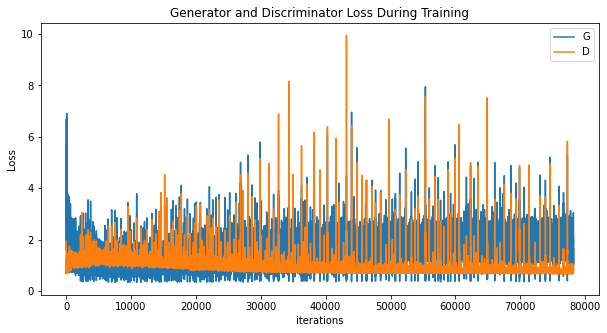

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Debug 专区

In [12]:
fake_img.shape

torch.Size([80, 3, 32, 32])

In [13]:
temp = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 5, 1, 0, bias=False),
            #nn.ConvTranspose2d(ngf * 4, ngf * 2, 5, 1, 0, bias=False)
            )

z = torch.randn(2, z_dim, 1, 1)
temp(z).shape

torch.Size([2, 256, 8, 8])